# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

D:\python\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# for tsne assignment you can take 5k data points
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews



GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()


(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:


display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:07<00:00, 1294.96it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
# printing some random reviews Summary
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

made in china
Not much taste
hot stuff
Great value


In [31]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

made in china


In [32]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
Summary= soup.get_text()
print(Summary)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
Summary = soup.get_text()
print(Summary)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
Summary = soup.get_text()
print(Summary)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
Summary = soup.get_text()
print(Summary)

made in china
Not much taste
hot stuff
Great value


In [33]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [34]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

hot stuff


In [35]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

made in china


In [36]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

hot stuff


In [37]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [38]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_Summary.append(sentance.strip())

 37%|███████████████████████████▌                                              | 32728/87773 [00:19<00:29, 1846.88it/s]D:\python\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▊                      | 61420/87773 [00:34<00:18, 1458.91it/s]D:\python\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▏                  | 65452/87773 [00:36<00:11, 1913.55it/s]D:\python\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % 

In [ ]:
len(preprocessed_Summary)

# [4] Featurization

## [4.1] BAG OF WORDS

In [40]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [41]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [42]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [43]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [46]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8456298112869263), ('awesome', 0.838829755783081), ('good', 0.8219473361968994), ('excellent', 0.8139351606369019), ('terrific', 0.8023746013641357), ('wonderful', 0.7904332876205444), ('perfect', 0.7624412775039673), ('amazing', 0.7509818077087402), ('nice', 0.7137444019317627), ('fabulous', 0.7086519598960876)]
[('greatest', 0.7488561868667603), ('best', 0.7310532331466675), ('surpass', 0.7299207448959351), ('tastiest', 0.7015678882598877), ('nastiest', 0.6805371642112732), ('awful', 0.6191368699073792), ('disgusting', 0.6189099550247192), ('horrible', 0.6148053407669067), ('closest', 0.6109057664871216), ('wins', 0.6091015338897705)]


In [47]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [06:59<00:00, 209.27it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [49]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [50]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [1:26:59<00:00, 16.82it/s]


# SAVED AS FILES (BOW,TD-IDF,AVG W2V,TD-IDF W2V)

In [ ]:
from scipy import sparse
sparse.save_npz("final_counts_BOW.npz",final_counts)
sparse.save_npz("final_tf_idf.npz",final_tf_idf)
np.save("w2v_words.npy",w2v_words)
np.save("tfidf_sent_vectors.npy",tfidf_sent_vectors)
#np.savetxt("preprocessed_reviews.csv",preprocessed_reviews)

In [52]:
#sparse matrix
final_counts=np.load("final_counts_BOW.npz")
final_tf_idf=np.load("final_tf_idf.npz")

#dense matrix
w2v_words=np.load("w2v_words.npy")
tfidf_sent_vectors=np.load("tfidf_sent_vectors.npy")



In [28]:
import pickle
with open("final['Score'].pkl",'wb') as f:
    pickle.dump(final['Score'],f)
import pickle
with open("preprocessed_reviews.pkl",'wb') as f:
    pickle.dump(preprocessed_reviews,f)

In [49]:
import pickle
with open("Final['Score'].pkl",'rb') as f :
    Final_score =pickle.load(f)
with open('preprocessed_reviews_check','rb') as f :
    preprocessed_reviews=pickle.load(f)

# TAKING 100K POINTS

In [50]:
# Please write all the code with proper documentation
y=Final_score[:100000].values
X=preprocessed_reviews[:100000]


# RANDOM SPLITTING THE DATA TO GET ONLY 60K

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

used, unused = train_test_split(final, test_size=0.30)


# LENGTH OF THE USEDDATA

In [52]:
len(used)

61442

In [53]:
len(preprocessed_reviews)

87773

# SORTING THE DATA BASED ON TIME

In [54]:
review=used.sort_values(by='Time')

# SPLITTING THE DATA INTO TEST TRAIN AND CV

In [514]:
x_train= preprocessed_reviews[:40000]
x_cv=    preprocessed_reviews[40000:50000]
x_test=  preprocessed_reviews[50000:60000]

y_train= Final_score[:40000]
y_cv=    Final_score[40000:50000]
y_test=  Final_score[50000:60000]

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [462]:
#train_BoW

count_vect = CountVectorizer() #in scikit-learn
train_bow = count_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_bow))
print("the shape of out text BOW vectorizer ",train_bow.get_shape())
print("the number of unique words ", train_bow.get_shape()[1])
print("********************************************")



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (40000, 37441)
the number of unique words  37441
********************************************


In [463]:
#cv_BoW
cv_bow = count_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_bow))
print("the shape of out text BOW vectorizer ",cv_bow.get_shape())
print("the number of unique words ", cv_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 37441)
the number of unique words  37441


In [464]:
#test_BoW
test_bow = count_vect.transform(x_test)
print("the type of count vectorizer ",type(test_bow))
print("the shape of out text BOW vectorizer ",test_bow.get_shape())
print("the number of unique words ", test_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 37441)
the number of unique words  37441


used fit_transform for train data but not for test and cv data because we want to fit the test and cv data in the train matrix

In [399]:
list_cv=[]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation traincc
    knn.fit(train_bow, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(cv_bow[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_test=pred


CV accuracy for k = 1 is 56.237653%

CV accuracy for k = 3 is 59.911992%

CV accuracy for k = 5 is 59.689980%

CV accuracy for k = 7 is 60.587678%

CV accuracy for k = 9 is 61.234550%

CV accuracy for k = 11 is 61.677424%

CV accuracy for k = 13 is 62.116577%

CV accuracy for k = 15 is 62.635646%

CV accuracy for k = 17 is 62.393368%

CV accuracy for k = 19 is 62.492096%

CV accuracy for k = 21 is 62.780345%

CV accuracy for k = 23 is 62.797471%

CV accuracy for k = 25 is 63.905186%

CV accuracy for k = 27 is 64.171652%

CV accuracy for k = 29 is 66.131293%
[0.5623765324679781, 0.5991199185298111, 0.5968998007362709, 0.6058767787903, 0.6123454970808967, 0.616774243753707, 0.6211657663442827, 0.6263564578114812, 0.6239336755702177, 0.6249209562698221, 0.6278034482674104, 0.6279747096827957, 0.6390518612653859, 0.6417165234484146, 0.661312934740516]


In [400]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation traincc
    knn.fit(train_bow, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(train_bow[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 95%

CV accuracy for k = 5 is 88%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 82%

CV accuracy for k = 13 is 81%

CV accuracy for k = 15 is 80%

CV accuracy for k = 17 is 80%

CV accuracy for k = 19 is 79%

CV accuracy for k = 21 is 79%

CV accuracy for k = 23 is 80%

CV accuracy for k = 25 is 81%

CV accuracy for k = 27 is 82%

CV accuracy for k = 29 is 83%
[0.999001996007984, 0.9560651166381685, 0.8877327530807908, 0.8590081615436109, 0.8387349110182601, 0.8201486086710108, 0.8112746692876066, 0.8054292341134686, 0.8016802298271136, 0.7986804234690948, 0.7990764381558173, 0.8020213153388017, 0.8137301952526629, 0.8231231624859808, 0.8336224260122023]


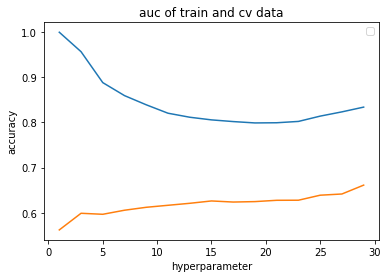

In [401]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [410]:
knn = KNeighborsClassifier(18)
knn.fit(train_bow,y_train)
pred_test= knn.predict(test_bow)
auc_test_1=roc_auc_score(y_test,pred_test)*100
print(auc_test_1) 

53.45704739901343


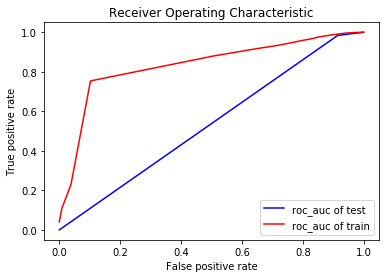

In [403]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

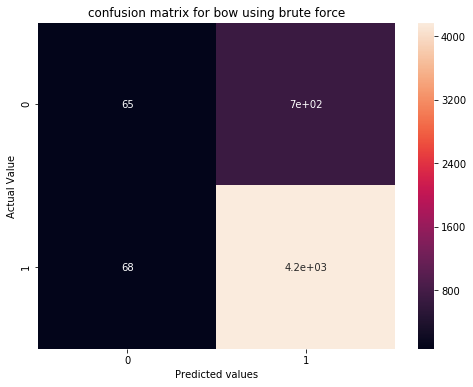

In [404]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_test,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using brute force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [465]:
# tfidf_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_tf_idf = tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (40000, 761783)
the number of unique words including both unigrams and bigrams  761783


In [466]:
# tfidf_test
test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(test_tf_idf))
print("the shape of out text TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", test_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 761783)
the number of unique words including both unigrams and bigrams  761783


In [467]:
# tdidf_cv

cv_tf_idf = tf_idf_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_tf_idf))
print("the shape of out text TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 761783)
the number of unique words including both unigrams and bigrams  761783


In [446]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="brute")

    # fitting the model on crossvalidation traincc
    knn.fit(train_tf_idf, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(train_tf_idf[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 99%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 81%

CV accuracy for k = 9 is 80%

CV accuracy for k = 11 is 78%

CV accuracy for k = 13 is 78%

CV accuracy for k = 15 is 78%

CV accuracy for k = 17 is 78%

CV accuracy for k = 19 is 80%

CV accuracy for k = 21 is 81%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 88%

CV accuracy for k = 27 is 95%

CV accuracy for k = 29 is 97%
[0.999001996007984, 0.999001996007984, 0.8532989726482463, 0.8181255863386013, 0.8024090299648634, 0.7898352602393973, 0.7819054919074018, 0.782137423791153, 0.7881649904850767, 0.8035674365442744, 0.8144170644235832, 0.8392531949948129, 0.8821051944990017, 0.9586841772889825, 0.9721377534445056]


In [412]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation traincc
    knn.fit(train_tf_idf, y_train)
    # predict the response on the crossvalidation train



    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(cv_tf_idf[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 50.000000%

CV accuracy for k = 3 is 50.000000%

CV accuracy for k = 5 is 47.696641%

CV accuracy for k = 7 is 48.809657%

CV accuracy for k = 9 is 48.173829%

CV accuracy for k = 11 is 48.790570%

CV accuracy for k = 13 is 49.801900%

CV accuracy for k = 15 is 49.933288%

CV accuracy for k = 17 is 49.583519%

CV accuracy for k = 19 is 49.642342%

CV accuracy for k = 21 is 50.345127%

CV accuracy for k = 23 is 50.335966%

CV accuracy for k = 25 is 50.208960%

CV accuracy for k = 27 is 50.000000%

CV accuracy for k = 29 is 63.947327%
[0.5, 0.5, 0.4769664119293533, 0.4880965657031093, 0.48173829417502856, 0.48790569654070326, 0.49801900480879996, 0.4993328770447204, 0.49583519198435305, 0.49642342439497855, 0.5034512698467164, 0.5033596649036034, 0.5020896037274327, 0.5, 0.6394732746408106]


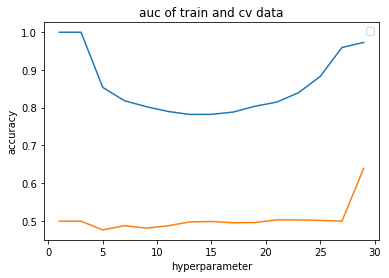

In [413]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [418]:
knn = KNeighborsClassifier(15)
knn.fit(train_tf_idf,y_train)
pred_test = knn.predict(test_tf_idf)
auc_test_1=roc_auc_score(y_test,pred)*100
print(auc_test_1) 

50.760881097712804


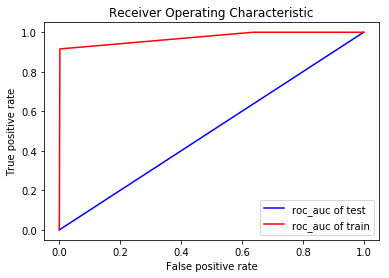

In [415]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

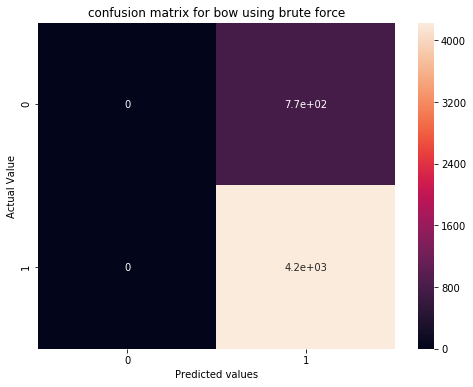

In [447]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using brute force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [478]:
# Train your own Word2Vec model using your own text corpus
i=0  
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

In [479]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model_train=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model_train.wv.most_similar('great'))
        print(w2v_model_train.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8281649351119995), ('awesome', 0.826367974281311), ('fantastic', 0.8137376308441162), ('excellent', 0.8042373657226562), ('perfect', 0.7759379744529724), ('amazing', 0.7658166885375977), ('wonderful', 0.7625890970230103), ('terrific', 0.7441879510879517), ('decent', 0.7290923595428467), ('fabulous', 0.6854006052017212)]
[('softest', 0.740280032157898), ('best', 0.7401491403579712), ('tastiest', 0.692924439907074), ('experienced', 0.6770994663238525), ('eaten', 0.6735028028488159), ('greatest', 0.6481723785400391), ('tasted', 0.6333077549934387), ('horrible', 0.6262240409851074), ('toughest', 0.6244502067565918), ('closest', 0.6231387853622437)]


In [480]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])


number of words that occured minimum 5 times  11989
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


In [481]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))





  0%|                                                                                        | 0/40000 [00:00<?, ?it/s]



  0%|                                                                              | 28/40000 [00:00<02:24, 277.39it/s]



  0%|                                                                              | 56/40000 [00:00<02:24, 277.38it/s]



  0%|▏                                                                             | 90/40000 [00:00<02:16, 291.39it/s]



  0%|▎                                                                            | 132/40000 [00:00<02:06, 314.42it/s]



  0%|▎                                                                            | 163/40000 [00:00<02:07, 311.25it/s]



  0%|▎                                                                            | 190/40000 [00:00<02:22, 280.08it/s]



  1%|▍                                                                            | 221/40000 [00:00<02:18, 287.67it/s]



  1%|▍      

  8%|██████▍                                                                     | 3370/40000 [00:16<03:02, 200.81it/s]



  8%|██████▍                                                                     | 3397/40000 [00:16<02:49, 215.48it/s]



  9%|██████▌                                                                     | 3440/40000 [00:17<02:25, 251.21it/s]



  9%|██████▌                                                                     | 3468/40000 [00:17<02:22, 255.70it/s]



  9%|██████▋                                                                     | 3510/40000 [00:17<02:06, 289.13it/s]



  9%|██████▋                                                                     | 3542/40000 [00:17<02:08, 282.80it/s]



  9%|██████▊                                                                     | 3573/40000 [00:17<02:32, 238.83it/s]



  9%|██████▊                                                                     | 3600/40000 [00:17<02:27, 246.08it/s]



  9%|██████▉    

 18%|██████████████                                                              | 7369/40000 [00:32<02:17, 236.76it/s]



 18%|██████████████                                                              | 7395/40000 [00:33<02:47, 195.14it/s]



 19%|██████████████                                                              | 7418/40000 [00:33<02:44, 198.13it/s]



 19%|██████████████▏                                                             | 7440/40000 [00:33<02:53, 187.55it/s]



 19%|██████████████▏                                                             | 7461/40000 [00:33<02:52, 189.08it/s]



 19%|██████████████▏                                                             | 7481/40000 [00:33<03:03, 177.43it/s]



 19%|██████████████▎                                                             | 7503/40000 [00:33<02:53, 186.95it/s]



 19%|██████████████▎                                                             | 7528/40000 [00:33<02:41, 200.82it/s]



 19%|███████████

 27%|████████████████████▎                                                      | 10853/40000 [00:49<03:01, 160.25it/s]



 27%|████████████████████▍                                                      | 10872/40000 [00:49<04:22, 110.82it/s]



 27%|████████████████████▍                                                      | 10895/40000 [00:49<03:42, 131.01it/s]



 27%|████████████████████▍                                                      | 10913/40000 [00:49<03:31, 137.45it/s]



 27%|████████████████████▌                                                      | 10934/40000 [00:49<03:10, 152.36it/s]



 27%|████████████████████▌                                                      | 10952/40000 [00:49<03:11, 152.06it/s]



 27%|████████████████████▌                                                      | 10970/40000 [00:49<03:14, 149.57it/s]



 27%|████████████████████▌                                                      | 10987/40000 [00:50<03:28, 138.85it/s]



 28%|███████████

 36%|██████████████████████████▊                                                | 14303/40000 [01:05<01:27, 292.76it/s]



 36%|██████████████████████████▉                                                | 14335/40000 [01:05<01:30, 283.71it/s]



 36%|██████████████████████████▉                                                | 14365/40000 [01:05<01:32, 276.50it/s]



 36%|██████████████████████████▉                                                | 14398/40000 [01:05<01:28, 289.15it/s]



 36%|███████████████████████████                                                | 14430/40000 [01:05<01:26, 296.98it/s]



 36%|███████████████████████████                                                | 14461/40000 [01:06<02:39, 160.62it/s]



 36%|███████████████████████████▏                                               | 14485/40000 [01:06<02:40, 159.19it/s]



 36%|███████████████████████████▏                                               | 14507/40000 [01:06<03:01, 140.39it/s]



 36%|███████████

 45%|█████████████████████████████████▌                                         | 17886/40000 [01:21<01:26, 254.73it/s]



 45%|█████████████████████████████████▌                                         | 17913/40000 [01:21<01:40, 220.47it/s]



 45%|█████████████████████████████████▋                                         | 17937/40000 [01:21<01:39, 221.64it/s]



 45%|█████████████████████████████████▋                                         | 17966/40000 [01:21<01:32, 237.95it/s]



 45%|█████████████████████████████████▋                                         | 17997/40000 [01:22<01:26, 253.32it/s]



 45%|█████████████████████████████████▊                                         | 18024/40000 [01:22<01:31, 239.60it/s]



 45%|█████████████████████████████████▊                                         | 18049/40000 [01:22<01:39, 220.23it/s]



 45%|█████████████████████████████████▉                                         | 18072/40000 [01:22<01:39, 219.91it/s]



 45%|███████████

 54%|████████████████████████████████████████▎                                  | 21480/40000 [01:37<01:14, 249.02it/s]



 54%|████████████████████████████████████████▎                                  | 21507/40000 [01:37<01:16, 241.34it/s]



 54%|████████████████████████████████████████▎                                  | 21533/40000 [01:37<01:24, 219.25it/s]



 54%|████████████████████████████████████████▍                                  | 21557/40000 [01:37<01:25, 215.43it/s]



 54%|████████████████████████████████████████▍                                  | 21580/40000 [01:37<01:24, 218.39it/s]



 54%|████████████████████████████████████████▌                                  | 21611/40000 [01:37<01:17, 238.56it/s]



 54%|████████████████████████████████████████▌                                  | 21643/40000 [01:37<01:12, 252.81it/s]



 54%|████████████████████████████████████████▋                                  | 21670/40000 [01:38<01:40, 182.90it/s]



 54%|███████████

 62%|██████████████████████████████████████████████▌                            | 24826/40000 [01:53<01:46, 142.67it/s]



 62%|██████████████████████████████████████████████▌                            | 24859/40000 [01:53<01:28, 171.16it/s]



 62%|██████████████████████████████████████████████▋                            | 24885/40000 [01:53<01:19, 189.07it/s]



 62%|██████████████████████████████████████████████▋                            | 24907/40000 [01:54<01:18, 192.25it/s]



 62%|██████████████████████████████████████████████▋                            | 24928/40000 [01:54<01:28, 171.24it/s]



 62%|██████████████████████████████████████████████▊                            | 24947/40000 [01:54<01:50, 135.68it/s]



 62%|██████████████████████████████████████████████▊                            | 24963/40000 [01:54<02:17, 109.73it/s]



 62%|██████████████████████████████████████████████▊                            | 24981/40000 [01:54<02:01, 123.79it/s]



 63%|███████████

 69%|███████████████████████████████████████████████████▊                       | 27617/40000 [02:10<01:15, 165.02it/s]



 69%|███████████████████████████████████████████████████▊                       | 27636/40000 [02:10<01:16, 161.32it/s]



 69%|███████████████████████████████████████████████████▊                       | 27658/40000 [02:10<01:11, 172.49it/s]



 69%|███████████████████████████████████████████████████▉                       | 27680/40000 [02:10<01:07, 183.55it/s]



 69%|███████████████████████████████████████████████████▉                       | 27701/40000 [02:10<01:05, 187.72it/s]



 69%|███████████████████████████████████████████████████▉                       | 27723/40000 [02:10<01:02, 195.34it/s]



 69%|████████████████████████████████████████████████████                       | 27744/40000 [02:11<01:11, 171.25it/s]



 69%|████████████████████████████████████████████████████                       | 27765/40000 [02:11<01:07, 180.38it/s]



 69%|███████████

 77%|█████████████████████████████████████████████████████████▍                 | 30624/40000 [02:26<00:38, 242.29it/s]



 77%|█████████████████████████████████████████████████████████▍                 | 30656/40000 [02:26<00:37, 249.17it/s]



 77%|█████████████████████████████████████████████████████████▌                 | 30682/40000 [02:26<00:39, 233.98it/s]



 77%|█████████████████████████████████████████████████████████▌                 | 30707/40000 [02:27<00:43, 211.92it/s]



 77%|█████████████████████████████████████████████████████████▌                 | 30730/40000 [02:27<00:45, 203.81it/s]



 77%|█████████████████████████████████████████████████████████▋                 | 30752/40000 [02:27<00:50, 182.07it/s]



 77%|█████████████████████████████████████████████████████████▋                 | 30772/40000 [02:27<00:54, 167.83it/s]



 77%|█████████████████████████████████████████████████████████▋                 | 30790/40000 [02:27<01:15, 121.67it/s]



 77%|███████████

 85%|███████████████████████████████████████████████████████████████▊           | 34002/40000 [02:42<00:29, 204.22it/s]



 85%|███████████████████████████████████████████████████████████████▊           | 34031/40000 [02:42<00:26, 222.59it/s]



 85%|███████████████████████████████████████████████████████████████▊           | 34055/40000 [02:43<00:29, 204.86it/s]



 85%|███████████████████████████████████████████████████████████████▉           | 34089/40000 [02:43<00:25, 231.67it/s]



 85%|███████████████████████████████████████████████████████████████▉           | 34116/40000 [02:43<00:24, 240.08it/s]



 85%|████████████████████████████████████████████████████████████████           | 34142/40000 [02:43<00:25, 227.70it/s]



 85%|████████████████████████████████████████████████████████████████           | 34166/40000 [02:43<00:29, 196.15it/s]



 85%|████████████████████████████████████████████████████████████████           | 34188/40000 [02:43<00:39, 147.68it/s]



 86%|███████████

 93%|█████████████████████████████████████████████████████████████████████▉     | 37321/40000 [02:59<00:19, 136.16it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 37337/40000 [02:59<00:20, 129.73it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 37353/40000 [02:59<00:19, 134.10it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 37369/40000 [02:59<00:18, 140.59it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 37387/40000 [02:59<00:17, 148.64it/s]



 94%|██████████████████████████████████████████████████████████████████████▏    | 37407/40000 [02:59<00:16, 160.29it/s]



 94%|██████████████████████████████████████████████████████████████████████▏    | 37449/40000 [02:59<00:12, 196.54it/s]



 94%|██████████████████████████████████████████████████████████████████████▎    | 37481/40000 [02:59<00:11, 220.91it/s]



 94%|███████████

40000
50


In [482]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [483]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
    print(w2v_model_test.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model_test.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model_test=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model_test.wv.most_similar('great'))
        print(w2v_model_test.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.791232705116272), ('makes', 0.7833784818649292), ('excellent', 0.7815295457839966), ('works', 0.7419764995574951), ('quick', 0.7355355024337769), ('well', 0.7323032021522522), ('looking', 0.7202582359313965), ('snack', 0.7176181077957153), ('super', 0.7158187627792358), ('wonderful', 0.7072880864143372)]


In [484]:
w2v_words_test= list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])


number of words that occured minimum 5 times  5896
sample words  ['second', 'order', 'like', 'brand', 'not', 'dioxide', 'company', 'front', 'ad', 'dental', 'gum', 'stated', 'contains', 'xylitol', 'reduces', 'bad', 'breath', 'prevents', 'tooth', 'decay', 'disease', 'no', 'unhealthy', 'sugar', 'cause', 'inflammation', 'body', 'promotes', 'sure', 'back', 'great', 'product', 'fast', 'easy', 'looking', 'hot', 'sauce', 'girlfriend', 'christmas', 'place', 'could', 'find', 'thanks', 'lives', 'ha', 'thank', 'taco', 'bought', 'military', 'grab']


In [475]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))





  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



  0%|▎                                                                             | 43/10000 [00:00<00:27, 367.74it/s]



  1%|▋                                                                             | 83/10000 [00:00<00:26, 374.80it/s]



  1%|█                                                                            | 141/10000 [00:00<00:23, 417.54it/s]



  2%|█▍                                                                           | 181/10000 [00:00<00:24, 402.25it/s]



  2%|█▋                                                                           | 214/10000 [00:00<00:28, 344.45it/s]



  3%|█▉                                                                           | 254/10000 [00:00<00:27, 358.51it/s]



  3%|██▏                                                                          | 288/10000 [00:00<00:30, 315.51it/s]



  3%|██▍    

 51%|██████████████████████████████████████▍                                     | 5053/10000 [00:15<00:25, 191.05it/s]



 51%|██████████████████████████████████████▋                                     | 5088/10000 [00:15<00:22, 220.37it/s]



 51%|██████████████████████████████████████▉                                     | 5117/10000 [00:15<00:20, 232.93it/s]



 52%|███████████████████████████████████████▏                                    | 5153/10000 [00:15<00:18, 258.87it/s]



 52%|███████████████████████████████████████▍                                    | 5185/10000 [00:16<00:17, 272.54it/s]



 52%|███████████████████████████████████████▋                                    | 5214/10000 [00:16<00:17, 275.23it/s]



 52%|███████████████████████████████████████▊                                    | 5243/10000 [00:16<00:17, 273.23it/s]



 53%|████████████████████████████████████████                                    | 5278/10000 [00:16<00:16, 285.37it/s]



 53%|███████████

 93%|██████████████████████████████████████████████████████████████████████▍     | 9276/10000 [00:31<00:02, 355.21it/s]



 93%|██████████████████████████████████████████████████████████████████████▊     | 9314/10000 [00:31<00:02, 327.69it/s]



 93%|███████████████████████████████████████████████████████████████████████     | 9349/10000 [00:32<00:01, 325.74it/s]



 94%|███████████████████████████████████████████████████████████████████████▍    | 9396/10000 [00:32<00:01, 355.57it/s]



 94%|███████████████████████████████████████████████████████████████████████▋    | 9434/10000 [00:32<00:01, 349.62it/s]



 95%|████████████████████████████████████████████████████████████████████████▏   | 9497/10000 [00:32<00:01, 402.76it/s]



 96%|████████████████████████████████████████████████████████████████████████▌   | 9553/10000 [00:32<00:01, 436.78it/s]



 96%|████████████████████████████████████████████████████████████████████████▉   | 9601/10000 [00:32<00:01, 383.39it/s]



 96%|███████████

10000
50


In [485]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())

In [486]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_cv=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
    print(w2v_model_cv.wv.most_similar('great'))
    print('='*50)
   # print(w2v_model_cv.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model_cv=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model_cv.wv.most_similar('great'))
        print(w2v_model_cv.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.9015371799468994), ('excellent', 0.8629840612411499), ('especially', 0.8069586157798767), ('fresh', 0.8017233610153198), ('tasty', 0.7743980884552002), ('makes', 0.7685225009918213), ('awsome', 0.7673854827880859), ('pretty', 0.7565003633499146), ('quick', 0.7503737211227417), ('easy', 0.7498546242713928)]


In [487]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_cv))
print("sample words ", w2v_words_cv[0:50])


number of words that occured minimum 5 times  5798
sample words  ['enjoy', 'coffee', 'much', 'easy', 'use', 'pod', 'bold', 'taste', 'extra', 'allows', 'largest', 'cup', 'size', 'keurig', 'flavor', 'smooth', 'rich', 'love', 'decaf', 'also', 'favorite', 'really', 'strong', 'likely', 'tried', 'running', 'another', 'ounces', 'water', 'k', 'could', 'drink', 'one', 'not', 'bitter', 'way', 'finally', 'added', 'little', 'milk', 'hershey', 'chocolate', 'syrup', 'good', 'used', 'able', 'buy', 'locally', 'thrilled', 'find']


In [488]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))





  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



  0%|▎                                                                             | 37/10000 [00:00<00:27, 362.95it/s]



  1%|▌                                                                             | 69/10000 [00:00<00:28, 346.70it/s]



  1%|▊                                                                            | 103/10000 [00:00<00:29, 339.56it/s]



  2%|█▏                                                                           | 153/10000 [00:00<00:26, 374.93it/s]



  2%|█▍                                                                           | 184/10000 [00:00<00:28, 344.60it/s]



  2%|█▋                                                                           | 218/10000 [00:00<00:28, 342.23it/s]



  2%|█▉                                                                           | 249/10000 [00:00<00:33, 291.67it/s]



  3%|██▏    

 49%|█████████████████████████████████████▌                                      | 4936/10000 [00:16<00:20, 250.02it/s]



 50%|█████████████████████████████████████▋                                      | 4966/10000 [00:16<00:19, 254.51it/s]



 50%|██████████████████████████████████████                                      | 5003/10000 [00:16<00:18, 276.43it/s]



 50%|██████████████████████████████████████▎                                     | 5042/10000 [00:16<00:16, 302.23it/s]



 51%|██████████████████████████████████████▌                                     | 5079/10000 [00:16<00:15, 319.03it/s]



 51%|██████████████████████████████████████▉                                     | 5117/10000 [00:16<00:14, 331.70it/s]



 52%|███████████████████████████████████████▎                                    | 5169/10000 [00:16<00:13, 366.66it/s]



 52%|███████████████████████████████████████▌                                    | 5208/10000 [00:17<00:15, 301.57it/s]



 52%|███████████

 96%|████████████████████████████████████████████████████████████████████████▋   | 9567/10000 [00:32<00:01, 261.19it/s]



 96%|████████████████████████████████████████████████████████████████████████▉   | 9598/10000 [00:32<00:01, 271.30it/s]



 96%|█████████████████████████████████████████████████████████████████████████▏  | 9636/10000 [00:32<00:01, 294.05it/s]



 97%|█████████████████████████████████████████████████████████████████████████▌  | 9679/10000 [00:32<00:00, 321.99it/s]



 97%|█████████████████████████████████████████████████████████████████████████▊  | 9717/10000 [00:32<00:00, 336.60it/s]



 98%|██████████████████████████████████████████████████████████████████████████▏ | 9758/10000 [00:32<00:00, 354.83it/s]



 98%|██████████████████████████████████████████████████████████████████████████▍ | 9796/10000 [00:32<00:00, 326.62it/s]



 98%|██████████████████████████████████████████████████████████████████████████▊ | 9839/10000 [00:32<00:00, 351.20it/s]



 99%|███████████

10000
50


In [460]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation traincc
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(sent_vectors_train[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 93%

CV accuracy for k = 5 is 89%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 84%

CV accuracy for k = 15 is 84%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 82%

CV accuracy for k = 23 is 82%

CV accuracy for k = 25 is 82%

CV accuracy for k = 27 is 82%

CV accuracy for k = 29 is 81%
[0.999001996007984, 0.9305069982431277, 0.899362939023291, 0.8776511548712232, 0.8622993313518112, 0.8510415519046252, 0.8452275551678017, 0.8406021114571298, 0.8344831266422473, 0.8314824589571788, 0.8278779227077993, 0.8256123976596648, 0.8238632773290656, 0.8214691013406868, 0.8195927003628772]


In [319]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation traincc
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(sent_vectors_cv[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 49.964522%

CV accuracy for k = 3 is 47.406401%

CV accuracy for k = 5 is 48.098232%

CV accuracy for k = 7 is 46.084884%

CV accuracy for k = 9 is 46.901562%

CV accuracy for k = 11 is 46.836903%

CV accuracy for k = 13 is 47.162070%

CV accuracy for k = 15 is 47.109481%

CV accuracy for k = 17 is 46.823959%

CV accuracy for k = 19 is 46.886290%

CV accuracy for k = 21 is 48.424809%

CV accuracy for k = 23 is 49.124667%

CV accuracy for k = 25 is 49.805271%

CV accuracy for k = 27 is 49.959283%

CV accuracy for k = 29 is 50.053063%
[0.49964522232734154, 0.474064005813697, 0.4809823236160607, 0.46084884387821634, 0.46901562369792305, 0.46836902760280585, 0.47162069671227097, 0.47109481080975096, 0.4682395858353636, 0.46886289773089346, 0.4842480857936971, 0.49124667281042744, 0.49805270562399206, 0.49959283287827017, 0.5005306346537517]


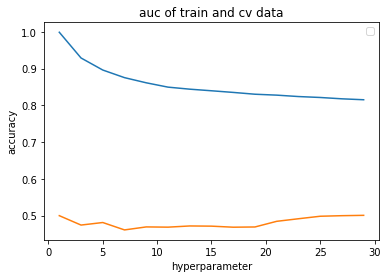

In [320]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [321]:
knn = KNeighborsClassifier(25)
knn.fit(sent_vectors_train,y_train)
pred_test= knn.predict(sent_vectors_test)
auc_test_1=roc_auc_score(y_test,pred)*100
print(auc_test_1) 

49.03157634902659


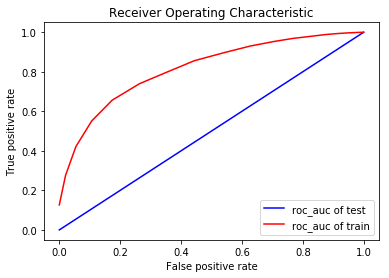

In [322]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

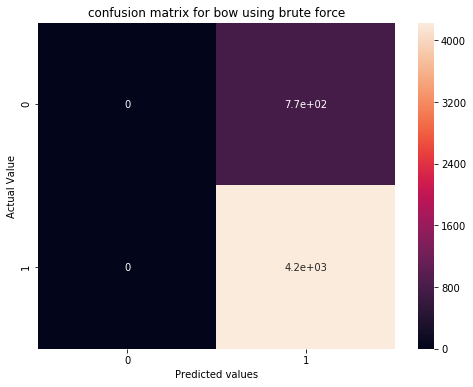

In [323]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using brute force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [515]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [517]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #  tf_idf = tf_idf_matrix_train[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1












  0%|                                                                                        | 0/40000 [00:00<?, ?it/s]










  0%|                                                                                | 3/40000 [00:00<25:32, 26.10it/s]










  0%|                                                                                | 7/40000 [00:00<23:16, 28.64it/s]










  0%|                                                                                | 9/40000 [00:00<29:16, 22.76it/s]










  0%|                                                                               | 13/40000 [00:00<27:05, 24.60it/s]










  0%|                                                                               | 17/40000 [00:00<26:36, 25.05it/s]










  0%|                                                                               | 20/40000 [00:00<27:44, 24.02it/s]










  0%|                                                                          

  1%|▍                                                                             | 212/40000 [00:10<43:36, 15.21it/s]










  1%|▍                                                                             | 215/40000 [00:10<37:40, 17.60it/s]










  1%|▍                                                                             | 218/40000 [00:10<35:31, 18.67it/s]










  1%|▍                                                                             | 221/40000 [00:10<47:59, 13.82it/s]










  1%|▍                                                                             | 223/40000 [00:11<47:00, 14.10it/s]










  1%|▍                                                                             | 225/40000 [00:11<45:13, 14.66it/s]










  1%|▍                                                                             | 229/40000 [00:11<38:30, 17.21it/s]










  1%|▍                                                                             | 232/4

  1%|█                                                                             | 544/40000 [00:32<34:29, 19.06it/s]










  1%|█                                                                             | 549/40000 [00:32<29:23, 22.37it/s]










  1%|█                                                                             | 552/40000 [00:33<27:55, 23.54it/s]










  1%|█                                                                             | 556/40000 [00:33<27:31, 23.88it/s]










  1%|█                                                                             | 559/40000 [00:33<29:54, 21.97it/s]










  1%|█                                                                             | 562/40000 [00:33<27:54, 23.56it/s]










  1%|█                                                                             | 565/40000 [00:33<27:32, 23.86it/s]










  1%|█                                                                             | 568/4

  2%|█▊                                                                            | 943/40000 [00:53<26:50, 24.26it/s]










  2%|█▊                                                                            | 946/40000 [00:53<27:06, 24.01it/s]










  2%|█▊                                                                            | 950/40000 [00:53<25:30, 25.51it/s]










  2%|█▊                                                                            | 953/40000 [00:53<25:47, 25.23it/s]










  2%|█▊                                                                            | 956/40000 [00:53<33:08, 19.64it/s]










  2%|█▊                                                                            | 960/40000 [00:53<30:19, 21.46it/s]










  2%|█▉                                                                            | 963/40000 [00:54<36:10, 17.98it/s]










  2%|█▉                                                                            | 966/4

  3%|██▋                                                                          | 1372/40000 [01:13<31:50, 20.22it/s]










  3%|██▋                                                                          | 1376/40000 [01:13<32:39, 19.71it/s]










  3%|██▋                                                                          | 1379/40000 [01:13<41:03, 15.68it/s]










  3%|██▋                                                                          | 1383/40000 [01:13<34:23, 18.72it/s]










  3%|██▋                                                                          | 1387/40000 [01:13<31:06, 20.69it/s]










  3%|██▋                                                                          | 1390/40000 [01:14<30:46, 20.91it/s]










  3%|██▋                                                                          | 1393/40000 [01:14<29:07, 22.09it/s]










  3%|██▋                                                                          | 1396/4

  4%|███▍                                                                         | 1786/40000 [01:32<28:35, 22.28it/s]










  4%|███▍                                                                         | 1790/40000 [01:33<26:38, 23.90it/s]










  4%|███▍                                                                         | 1793/40000 [01:33<28:30, 22.33it/s]










  4%|███▍                                                                         | 1798/40000 [01:33<25:08, 25.32it/s]










  5%|███▍                                                                         | 1801/40000 [01:33<24:28, 26.01it/s]










  5%|███▍                                                                         | 1804/40000 [01:33<24:53, 25.57it/s]










  5%|███▍                                                                         | 1807/40000 [01:33<30:43, 20.72it/s]










  5%|███▍                                                                         | 1812/4

  6%|████▎                                                                        | 2226/40000 [01:53<30:02, 20.96it/s]










  6%|████▎                                                                        | 2229/40000 [01:53<29:23, 21.42it/s]










  6%|████▎                                                                        | 2232/40000 [01:53<28:52, 21.80it/s]










  6%|████▎                                                                        | 2235/40000 [01:54<29:12, 21.55it/s]










  6%|████▎                                                                        | 2240/40000 [01:54<24:35, 25.59it/s]










  6%|████▎                                                                        | 2243/40000 [01:54<25:42, 24.48it/s]










  6%|████▎                                                                        | 2246/40000 [01:54<27:21, 23.00it/s]










  6%|████▎                                                                        | 2249/4

  7%|█████▏                                                                       | 2679/40000 [02:12<27:39, 22.48it/s]










  7%|█████▏                                                                       | 2682/40000 [02:13<27:15, 22.82it/s]










  7%|█████▏                                                                       | 2685/40000 [02:13<26:21, 23.60it/s]










  7%|█████▏                                                                       | 2688/40000 [02:13<32:18, 19.25it/s]










  7%|█████▏                                                                       | 2693/40000 [02:13<28:50, 21.56it/s]










  7%|█████▏                                                                       | 2696/40000 [02:13<26:53, 23.12it/s]










  7%|█████▏                                                                       | 2699/40000 [02:13<29:04, 21.38it/s]










  7%|█████▏                                                                       | 2705/4

  8%|██████                                                                       | 3124/40000 [02:33<38:32, 15.95it/s]










  8%|██████                                                                       | 3127/40000 [02:33<37:32, 16.37it/s]










  8%|██████                                                                       | 3133/40000 [02:33<30:52, 19.90it/s]










  8%|██████                                                                       | 3136/40000 [02:34<32:21, 18.99it/s]










  8%|██████                                                                       | 3143/40000 [02:34<26:26, 23.24it/s]










  8%|██████                                                                       | 3149/40000 [02:34<23:00, 26.69it/s]










  8%|██████                                                                       | 3153/40000 [02:34<22:05, 27.80it/s]










  8%|██████                                                                       | 3158/4

  9%|██████▊                                                                      | 3527/40000 [02:55<28:20, 21.45it/s]










  9%|██████▊                                                                      | 3531/40000 [02:55<26:26, 22.98it/s]










  9%|██████▊                                                                      | 3534/40000 [02:55<25:15, 24.07it/s]










  9%|██████▊                                                                      | 3537/40000 [02:55<36:59, 16.43it/s]










  9%|██████▊                                                                      | 3540/40000 [02:55<32:34, 18.66it/s]










  9%|██████▊                                                                      | 3543/40000 [02:55<29:43, 20.44it/s]










  9%|██████▊                                                                      | 3546/40000 [02:56<38:39, 15.72it/s]










  9%|██████▊                                                                      | 3549/4

 10%|███████▌                                                                     | 3917/40000 [03:16<33:47, 17.80it/s]










 10%|███████▌                                                                     | 3920/40000 [03:16<31:49, 18.89it/s]










 10%|███████▌                                                                     | 3923/40000 [03:16<30:01, 20.02it/s]










 10%|███████▌                                                                     | 3926/40000 [03:16<27:37, 21.76it/s]










 10%|███████▌                                                                     | 3929/40000 [03:16<31:57, 18.81it/s]










 10%|███████▌                                                                     | 3933/40000 [03:17<27:32, 21.82it/s]










 10%|███████▌                                                                     | 3936/40000 [03:17<25:31, 23.54it/s]










 10%|███████▌                                                                     | 3939/4

 11%|████████▎                                                                    | 4345/40000 [03:37<40:01, 14.85it/s]










 11%|████████▎                                                                    | 4348/40000 [03:37<43:59, 13.51it/s]










 11%|████████▍                                                                    | 4351/40000 [03:37<40:17, 14.75it/s]










 11%|████████▍                                                                    | 4354/40000 [03:37<35:30, 16.73it/s]










 11%|████████▍                                                                    | 4357/40000 [03:37<31:37, 18.79it/s]










 11%|████████▍                                                                    | 4360/40000 [03:37<31:02, 19.14it/s]










 11%|████████▍                                                                    | 4363/40000 [03:37<29:37, 20.05it/s]










 11%|████████▍                                                                    | 4366/4

 12%|█████████▏                                                                   | 4761/40000 [03:56<36:34, 16.05it/s]










 12%|█████████▏                                                                   | 4764/40000 [03:57<34:06, 17.21it/s]










 12%|█████████▏                                                                   | 4767/40000 [03:57<32:16, 18.20it/s]










 12%|█████████▏                                                                   | 4769/40000 [03:57<34:12, 17.16it/s]










 12%|█████████▏                                                                   | 4771/40000 [03:57<49:22, 11.89it/s]










 12%|█████████▏                                                                   | 4774/40000 [03:57<41:15, 14.23it/s]










 12%|█████████▏                                                                   | 4777/40000 [03:57<35:51, 16.37it/s]










 12%|█████████▏                                                                   | 4780/4

 13%|█████████▉                                                                   | 5164/40000 [04:17<27:58, 20.75it/s]










 13%|█████████▉                                                                   | 5169/40000 [04:17<24:31, 23.67it/s]










 13%|█████████▉                                                                   | 5173/40000 [04:17<23:49, 24.36it/s]










 13%|█████████▉                                                                   | 5176/40000 [04:17<23:20, 24.86it/s]










 13%|█████████▉                                                                   | 5179/40000 [04:17<23:25, 24.78it/s]










 13%|█████████▉                                                                   | 5182/40000 [04:17<22:14, 26.08it/s]










 13%|█████████▉                                                                   | 5185/40000 [04:17<24:54, 23.29it/s]










 13%|█████████▉                                                                   | 5188/4

 14%|██████████▊                                                                  | 5597/40000 [04:35<22:31, 25.45it/s]










 14%|██████████▊                                                                  | 5600/40000 [04:35<24:52, 23.05it/s]










 14%|██████████▊                                                                  | 5603/40000 [04:35<30:18, 18.92it/s]










 14%|██████████▊                                                                  | 5607/40000 [04:35<25:33, 22.43it/s]










 14%|██████████▊                                                                  | 5610/40000 [04:36<38:44, 14.80it/s]










 14%|██████████▊                                                                  | 5613/40000 [04:36<40:10, 14.27it/s]










 14%|██████████▊                                                                  | 5615/40000 [04:36<38:56, 14.72it/s]










 14%|██████████▊                                                                  | 5618/4

 15%|███████████▌                                                                 | 5990/40000 [04:55<35:52, 15.80it/s]










 15%|███████████▌                                                                 | 5992/40000 [04:55<37:30, 15.11it/s]










 15%|███████████▌                                                                 | 5994/40000 [04:56<59:18,  9.56it/s]










 15%|███████████▌                                                                 | 5996/40000 [04:56<56:07, 10.10it/s]










 15%|███████████▌                                                                 | 5998/40000 [04:56<53:38, 10.56it/s]










 15%|███████████▌                                                                 | 6000/40000 [04:56<59:07,  9.58it/s]










 15%|███████████▌                                                                 | 6003/40000 [04:56<49:05, 11.54it/s]










 15%|███████████▌                                                                 | 6007/4

 16%|████████████▏                                                                | 6349/40000 [05:17<46:51, 11.97it/s]










 16%|████████████▏                                                                | 6351/40000 [05:17<42:33, 13.18it/s]










 16%|████████████▏                                                                | 6353/40000 [05:17<44:34, 12.58it/s]










 16%|████████████▏                                                                | 6355/40000 [05:17<40:12, 13.95it/s]










 16%|████████████▏                                                                | 6358/40000 [05:17<37:39, 14.89it/s]










 16%|████████████▏                                                                | 6360/40000 [05:17<55:26, 10.11it/s]










 16%|████████████▏                                                                | 6363/40000 [05:18<45:11, 12.40it/s]










 16%|████████████▎                                                                | 6365/4

 17%|████████████▉                                                                | 6732/40000 [05:37<27:26, 20.20it/s]










 17%|████████████▉                                                                | 6735/40000 [05:37<32:14, 17.20it/s]










 17%|████████████▉                                                                | 6738/40000 [05:37<35:08, 15.78it/s]










 17%|████████████▉                                                                | 6744/40000 [05:38<29:23, 18.86it/s]










 17%|████████████▉                                                                | 6747/40000 [05:38<33:55, 16.34it/s]










 17%|████████████▉                                                                | 6750/40000 [05:38<31:22, 17.66it/s]










 17%|████████████▉                                                                | 6753/40000 [05:38<29:49, 18.58it/s]










 17%|█████████████                                                                | 6756/4

 18%|█████████████▊                                                               | 7174/40000 [05:57<36:31, 14.98it/s]










 18%|█████████████▊                                                               | 7176/40000 [05:57<40:54, 13.38it/s]










 18%|█████████████▊                                                               | 7179/40000 [05:57<35:57, 15.21it/s]










 18%|█████████████▊                                                               | 7181/40000 [05:58<35:44, 15.30it/s]










 18%|█████████████▊                                                               | 7183/40000 [05:58<36:34, 14.95it/s]










 18%|█████████████▊                                                               | 7185/40000 [05:58<37:00, 14.78it/s]










 18%|█████████████▊                                                               | 7188/40000 [05:58<33:36, 16.27it/s]










 18%|█████████████▊                                                               | 7191/4

 19%|██████████████▌                                                              | 7582/40000 [06:17<19:39, 27.48it/s]










 19%|██████████████▌                                                              | 7585/40000 [06:17<22:40, 23.83it/s]










 19%|██████████████▌                                                              | 7588/40000 [06:17<25:35, 21.11it/s]










 19%|██████████████▌                                                              | 7591/40000 [06:17<24:13, 22.30it/s]










 19%|██████████████▌                                                              | 7594/40000 [06:17<22:30, 23.99it/s]










 19%|██████████████▌                                                              | 7597/40000 [06:17<21:19, 25.33it/s]










 19%|██████████████▋                                                              | 7602/40000 [06:17<18:58, 28.47it/s]










 19%|██████████████▋                                                              | 7606/4

 20%|███████████████▍                                                             | 7989/40000 [06:36<21:57, 24.30it/s]










 20%|███████████████▍                                                             | 7992/40000 [06:36<22:24, 23.81it/s]










 20%|███████████████▍                                                             | 7995/40000 [06:36<21:35, 24.70it/s]










 20%|███████████████▍                                                             | 8001/40000 [06:36<17:51, 29.86it/s]










 20%|███████████████▍                                                             | 8005/40000 [06:36<21:53, 24.35it/s]










 20%|███████████████▍                                                             | 8009/40000 [06:36<24:14, 22.00it/s]










 20%|███████████████▍                                                             | 8012/40000 [06:37<26:04, 20.45it/s]










 20%|███████████████▍                                                             | 8016/4

 21%|████████████████▏                                                            | 8411/40000 [06:57<38:32, 13.66it/s]










 21%|████████████████▏                                                            | 8413/40000 [06:57<36:03, 14.60it/s]










 21%|████████████████▏                                                            | 8416/40000 [06:57<35:23, 14.87it/s]










 21%|████████████████▏                                                            | 8420/40000 [06:58<29:20, 17.93it/s]










 21%|████████████████▏                                                            | 8423/40000 [06:58<29:16, 17.98it/s]










 21%|████████████████▏                                                            | 8427/40000 [06:58<25:32, 20.61it/s]










 21%|████████████████▏                                                            | 8430/40000 [06:58<24:52, 21.16it/s]










 21%|████████████████▏                                                            | 8433/4

 22%|████████████████▉                                                            | 8817/40000 [07:16<19:53, 26.13it/s]










 22%|████████████████▉                                                            | 8820/40000 [07:16<22:57, 22.64it/s]










 22%|████████████████▉                                                            | 8826/40000 [07:16<19:07, 27.16it/s]










 22%|████████████████▉                                                            | 8830/40000 [07:16<20:09, 25.76it/s]










 22%|█████████████████                                                            | 8833/40000 [07:17<20:33, 25.27it/s]










 22%|█████████████████                                                            | 8837/40000 [07:17<18:42, 27.77it/s]










 22%|█████████████████                                                            | 8841/40000 [07:17<17:20, 29.96it/s]










 22%|█████████████████                                                            | 8846/4

 23%|█████████████████▊                                                           | 9224/40000 [07:35<18:33, 27.63it/s]










 23%|█████████████████▊                                                           | 9228/40000 [07:35<18:50, 27.23it/s]










 23%|█████████████████▊                                                           | 9233/40000 [07:35<16:26, 31.19it/s]










 23%|█████████████████▊                                                           | 9237/40000 [07:36<17:48, 28.79it/s]










 23%|█████████████████▊                                                           | 9241/40000 [07:36<17:11, 29.82it/s]










 23%|█████████████████▊                                                           | 9245/40000 [07:36<16:36, 30.87it/s]










 23%|█████████████████▊                                                           | 9249/40000 [07:36<15:39, 32.74it/s]










 23%|█████████████████▊                                                           | 9253/4

 24%|██████████████████▌                                                          | 9651/40000 [07:55<22:11, 22.79it/s]










 24%|██████████████████▌                                                          | 9654/40000 [07:55<26:20, 19.20it/s]










 24%|██████████████████▌                                                          | 9657/40000 [07:56<24:51, 20.34it/s]










 24%|██████████████████▌                                                          | 9660/40000 [07:56<23:06, 21.88it/s]










 24%|██████████████████▌                                                          | 9663/40000 [07:56<26:59, 18.73it/s]










 24%|██████████████████▌                                                          | 9667/40000 [07:56<23:53, 21.16it/s]










 24%|██████████████████▌                                                          | 9670/40000 [07:56<28:26, 17.77it/s]










 24%|██████████████████▌                                                          | 9673/4

 25%|███████████████████                                                         | 10055/40000 [08:15<21:10, 23.56it/s]










 25%|███████████████████                                                         | 10059/40000 [08:15<21:44, 22.95it/s]










 25%|███████████████████                                                         | 10063/40000 [08:15<19:15, 25.91it/s]










 25%|███████████████████▏                                                        | 10066/40000 [08:15<19:00, 26.24it/s]










 25%|███████████████████▏                                                        | 10069/40000 [08:16<26:28, 18.85it/s]










 25%|███████████████████▏                                                        | 10072/40000 [08:16<23:48, 20.95it/s]










 25%|███████████████████▏                                                        | 10075/40000 [08:16<24:50, 20.08it/s]










 25%|███████████████████▏                                                        | 10078/4

 26%|███████████████████▉                                                        | 10491/40000 [08:35<26:27, 18.59it/s]










 26%|███████████████████▉                                                        | 10495/40000 [08:35<22:47, 21.58it/s]










 26%|███████████████████▉                                                        | 10498/40000 [08:35<24:30, 20.07it/s]










 26%|███████████████████▉                                                        | 10501/40000 [08:36<24:51, 19.77it/s]










 26%|███████████████████▉                                                        | 10504/40000 [08:36<55:02,  8.93it/s]










 26%|███████████████████▉                                                        | 10506/40000 [08:36<46:11, 10.64it/s]










 26%|███████████████████▉                                                        | 10508/40000 [08:37<55:23,  8.87it/s]










 26%|███████████████████▉                                                        | 10510/4

 27%|████████████████████▋                                                       | 10903/40000 [08:56<21:13, 22.85it/s]










 27%|████████████████████▋                                                       | 10907/40000 [08:56<20:09, 24.05it/s]










 27%|████████████████████▋                                                       | 10910/40000 [08:56<20:56, 23.15it/s]










 27%|████████████████████▋                                                       | 10913/40000 [08:56<20:40, 23.46it/s]










 27%|████████████████████▋                                                       | 10916/40000 [08:56<19:27, 24.91it/s]










 27%|████████████████████▋                                                       | 10919/40000 [08:57<20:21, 23.82it/s]










 27%|████████████████████▊                                                       | 10922/40000 [08:57<20:03, 24.16it/s]










 27%|████████████████████▊                                                       | 10925/4

 28%|█████████████████████▌                                                      | 11379/40000 [09:15<25:18, 18.84it/s]










 28%|█████████████████████▋                                                      | 11383/40000 [09:15<24:39, 19.35it/s]










 28%|█████████████████████▋                                                      | 11386/40000 [09:15<26:07, 18.26it/s]










 28%|█████████████████████▋                                                      | 11389/40000 [09:15<26:11, 18.20it/s]










 28%|█████████████████████▋                                                      | 11394/40000 [09:15<21:40, 21.99it/s]










 28%|█████████████████████▋                                                      | 11398/40000 [09:16<19:38, 24.27it/s]










 29%|█████████████████████▋                                                      | 11401/40000 [09:16<20:19, 23.46it/s]










 29%|█████████████████████▋                                                      | 11404/4

 30%|██████████████████████▍                                                     | 11827/40000 [09:34<22:39, 20.73it/s]










 30%|██████████████████████▍                                                     | 11831/40000 [09:34<19:28, 24.10it/s]










 30%|██████████████████████▍                                                     | 11835/40000 [09:34<19:22, 24.23it/s]










 30%|██████████████████████▍                                                     | 11838/40000 [09:34<19:59, 23.49it/s]










 30%|██████████████████████▍                                                     | 11842/40000 [09:34<17:45, 26.44it/s]










 30%|██████████████████████▌                                                     | 11845/40000 [09:34<18:42, 25.08it/s]










 30%|██████████████████████▌                                                     | 11850/40000 [09:34<17:05, 27.45it/s]










 30%|██████████████████████▌                                                     | 11855/4

 31%|███████████████████████▎                                                    | 12299/40000 [09:53<24:07, 19.13it/s]










 31%|███████████████████████▍                                                    | 12303/40000 [09:53<20:31, 22.49it/s]










 31%|███████████████████████▍                                                    | 12307/40000 [09:54<22:06, 20.87it/s]










 31%|███████████████████████▍                                                    | 12310/40000 [09:54<24:39, 18.72it/s]










 31%|███████████████████████▍                                                    | 12313/40000 [09:54<23:37, 19.54it/s]










 31%|███████████████████████▍                                                    | 12316/40000 [09:54<23:21, 19.75it/s]










 31%|███████████████████████▍                                                    | 12322/40000 [09:54<18:47, 24.55it/s]










 31%|███████████████████████▍                                                    | 12326/4

 32%|████████████████████████▏                                                   | 12707/40000 [10:15<34:43, 13.10it/s]










 32%|████████████████████████▏                                                   | 12709/40000 [10:15<36:26, 12.48it/s]










 32%|████████████████████████▏                                                   | 12711/40000 [10:15<33:24, 13.61it/s]










 32%|████████████████████████▏                                                   | 12714/40000 [10:15<28:17, 16.07it/s]










 32%|████████████████████████▏                                                   | 12716/40000 [10:15<28:52, 15.75it/s]










 32%|████████████████████████▏                                                   | 12719/40000 [10:16<31:58, 14.22it/s]










 32%|████████████████████████▏                                                   | 12721/40000 [10:16<29:48, 15.25it/s]










 32%|████████████████████████▏                                                   | 12724/4

 33%|████████████████████████▊                                                   | 13092/40000 [10:35<29:15, 15.33it/s]










 33%|████████████████████████▉                                                   | 13095/40000 [10:35<28:14, 15.88it/s]










 33%|████████████████████████▉                                                   | 13098/40000 [10:35<28:35, 15.68it/s]










 33%|████████████████████████▉                                                   | 13101/40000 [10:36<25:58, 17.26it/s]










 33%|████████████████████████▉                                                   | 13104/40000 [10:36<22:58, 19.51it/s]










 33%|████████████████████████▉                                                   | 13107/40000 [10:36<21:35, 20.76it/s]










 33%|████████████████████████▉                                                   | 13110/40000 [10:36<20:58, 21.36it/s]










 33%|████████████████████████▉                                                   | 13114/4

 34%|█████████████████████████▌                                                  | 13453/40000 [10:56<34:10, 12.95it/s]










 34%|█████████████████████████▌                                                  | 13455/40000 [10:56<37:46, 11.71it/s]










 34%|█████████████████████████▌                                                  | 13458/40000 [10:57<34:00, 13.01it/s]










 34%|█████████████████████████▌                                                  | 13460/40000 [10:57<41:22, 10.69it/s]










 34%|█████████████████████████▌                                                  | 13462/40000 [10:57<38:50, 11.39it/s]










 34%|█████████████████████████▌                                                  | 13465/40000 [10:57<35:26, 12.48it/s]










 34%|█████████████████████████▌                                                  | 13468/40000 [10:57<30:36, 14.45it/s]










 34%|█████████████████████████▌                                                  | 13471/4

 35%|██████████████████████████▎                                                 | 13871/40000 [11:17<25:23, 17.15it/s]










 35%|██████████████████████████▎                                                 | 13874/40000 [11:17<24:57, 17.45it/s]










 35%|██████████████████████████▎                                                 | 13877/40000 [11:17<22:02, 19.76it/s]










 35%|██████████████████████████▎                                                 | 13880/40000 [11:17<27:15, 15.97it/s]










 35%|██████████████████████████▍                                                 | 13883/40000 [11:17<25:10, 17.29it/s]










 35%|██████████████████████████▍                                                 | 13886/40000 [11:17<23:31, 18.50it/s]










 35%|██████████████████████████▍                                                 | 13889/40000 [11:18<24:07, 18.04it/s]










 35%|██████████████████████████▍                                                 | 13891/4

 36%|███████████████████████████▏                                                | 14277/40000 [11:36<19:28, 22.00it/s]










 36%|███████████████████████████▏                                                | 14280/40000 [11:36<22:35, 18.98it/s]










 36%|███████████████████████████▏                                                | 14283/40000 [11:36<23:46, 18.02it/s]










 36%|███████████████████████████▏                                                | 14286/40000 [11:37<25:28, 16.83it/s]










 36%|███████████████████████████▏                                                | 14289/40000 [11:37<22:11, 19.31it/s]










 36%|███████████████████████████▏                                                | 14292/40000 [11:37<21:47, 19.67it/s]










 36%|███████████████████████████▏                                                | 14296/40000 [11:37<19:23, 22.09it/s]










 36%|███████████████████████████▏                                                | 14301/4

 37%|███████████████████████████▉                                                | 14682/40000 [11:57<17:58, 23.49it/s]










 37%|███████████████████████████▉                                                | 14685/40000 [11:57<24:22, 17.30it/s]










 37%|███████████████████████████▉                                                | 14689/40000 [11:57<22:37, 18.64it/s]










 37%|███████████████████████████▉                                                | 14692/40000 [11:57<21:39, 19.48it/s]










 37%|███████████████████████████▉                                                | 14695/40000 [11:57<21:06, 19.99it/s]










 37%|███████████████████████████▉                                                | 14698/40000 [11:58<19:44, 21.36it/s]










 37%|███████████████████████████▉                                                | 14702/40000 [11:58<17:46, 23.73it/s]










 37%|███████████████████████████▉                                                | 14706/4

 38%|████████████████████████████▋                                               | 15122/40000 [12:16<17:24, 23.83it/s]










 38%|████████████████████████████▋                                               | 15125/40000 [12:16<22:02, 18.81it/s]










 38%|████████████████████████████▋                                               | 15129/40000 [12:16<18:35, 22.29it/s]










 38%|████████████████████████████▊                                               | 15132/40000 [12:16<21:03, 19.69it/s]










 38%|████████████████████████████▊                                               | 15137/40000 [12:16<17:57, 23.07it/s]










 38%|████████████████████████████▊                                               | 15140/40000 [12:16<18:34, 22.30it/s]










 38%|████████████████████████████▊                                               | 15143/40000 [12:17<19:57, 20.76it/s]










 38%|████████████████████████████▊                                               | 15146/4

 39%|█████████████████████████████▌                                              | 15529/40000 [12:35<14:33, 28.00it/s]










 39%|█████████████████████████████▌                                              | 15533/40000 [12:36<16:36, 24.55it/s]










 39%|█████████████████████████████▌                                              | 15536/40000 [12:36<15:59, 25.50it/s]










 39%|█████████████████████████████▌                                              | 15539/40000 [12:36<22:40, 17.98it/s]










 39%|█████████████████████████████▌                                              | 15543/40000 [12:36<20:09, 20.23it/s]










 39%|█████████████████████████████▌                                              | 15546/40000 [12:36<22:07, 18.42it/s]










 39%|█████████████████████████████▌                                              | 15551/40000 [12:36<19:23, 21.01it/s]










 39%|█████████████████████████████▌                                              | 15555/4

 40%|██████████████████████████████▎                                             | 15972/40000 [12:55<18:33, 21.58it/s]










 40%|██████████████████████████████▎                                             | 15975/40000 [12:56<17:16, 23.18it/s]










 40%|██████████████████████████████▎                                             | 15978/40000 [12:56<16:41, 23.99it/s]










 40%|██████████████████████████████▎                                             | 15982/40000 [12:56<15:20, 26.09it/s]










 40%|██████████████████████████████▎                                             | 15985/40000 [12:56<15:03, 26.58it/s]










 40%|██████████████████████████████▍                                             | 15988/40000 [12:56<19:22, 20.65it/s]










 40%|██████████████████████████████▍                                             | 15992/40000 [12:56<19:30, 20.52it/s]










 40%|██████████████████████████████▍                                             | 15995/4

 41%|███████████████████████████████▏                                            | 16407/40000 [13:15<15:31, 25.33it/s]










 41%|███████████████████████████████▏                                            | 16410/40000 [13:15<19:54, 19.75it/s]










 41%|███████████████████████████████▏                                            | 16415/40000 [13:15<16:28, 23.86it/s]










 41%|███████████████████████████████▏                                            | 16419/40000 [13:16<15:05, 26.04it/s]










 41%|███████████████████████████████▏                                            | 16423/40000 [13:16<18:43, 20.99it/s]










 41%|███████████████████████████████▏                                            | 16428/40000 [13:16<15:30, 25.33it/s]










 41%|███████████████████████████████▏                                            | 16432/40000 [13:16<17:23, 22.59it/s]










 41%|███████████████████████████████▏                                            | 16437/4

 42%|███████████████████████████████▉                                            | 16819/40000 [13:35<13:28, 28.67it/s]










 42%|███████████████████████████████▉                                            | 16824/40000 [13:35<12:52, 29.99it/s]










 42%|███████████████████████████████▉                                            | 16829/40000 [13:35<15:11, 25.41it/s]










 42%|███████████████████████████████▉                                            | 16833/40000 [13:35<13:33, 28.47it/s]










 42%|███████████████████████████████▉                                            | 16837/40000 [13:36<15:07, 25.51it/s]










 42%|███████████████████████████████▉                                            | 16841/40000 [13:36<15:23, 25.07it/s]










 42%|████████████████████████████████                                            | 16844/40000 [13:36<24:18, 15.87it/s]










 42%|████████████████████████████████                                            | 16847/4

 43%|████████████████████████████████▊                                           | 17242/40000 [13:55<19:39, 19.30it/s]










 43%|████████████████████████████████▊                                           | 17247/40000 [13:55<16:56, 22.39it/s]










 43%|████████████████████████████████▊                                           | 17251/40000 [13:55<14:52, 25.50it/s]










 43%|████████████████████████████████▊                                           | 17254/40000 [13:55<19:20, 19.59it/s]










 43%|████████████████████████████████▊                                           | 17258/40000 [13:55<17:32, 21.60it/s]










 43%|████████████████████████████████▊                                           | 17261/40000 [13:56<17:37, 21.51it/s]










 43%|████████████████████████████████▊                                           | 17264/40000 [13:56<17:42, 21.39it/s]










 43%|████████████████████████████████▊                                           | 17267/4

 44%|█████████████████████████████████▌                                          | 17662/40000 [14:13<13:34, 27.42it/s]










 44%|█████████████████████████████████▌                                          | 17667/40000 [14:14<12:17, 30.28it/s]










 44%|█████████████████████████████████▌                                          | 17671/40000 [14:14<15:16, 24.37it/s]










 44%|█████████████████████████████████▌                                          | 17675/40000 [14:14<13:58, 26.62it/s]










 44%|█████████████████████████████████▌                                          | 17678/40000 [14:14<17:37, 21.10it/s]










 44%|█████████████████████████████████▌                                          | 17681/40000 [14:14<16:39, 22.34it/s]










 44%|█████████████████████████████████▌                                          | 17684/40000 [14:14<15:51, 23.46it/s]










 44%|█████████████████████████████████▌                                          | 17687/4

 45%|██████████████████████████████████▍                                         | 18107/40000 [14:34<21:16, 17.15it/s]










 45%|██████████████████████████████████▍                                         | 18110/40000 [14:34<19:31, 18.69it/s]










 45%|██████████████████████████████████▍                                         | 18113/40000 [14:34<19:31, 18.68it/s]










 45%|██████████████████████████████████▍                                         | 18118/40000 [14:34<16:01, 22.75it/s]










 45%|██████████████████████████████████▍                                         | 18121/40000 [14:34<22:24, 16.27it/s]










 45%|██████████████████████████████████▍                                         | 18124/40000 [14:35<20:05, 18.15it/s]










 45%|██████████████████████████████████▍                                         | 18129/40000 [14:35<16:52, 21.59it/s]










 45%|██████████████████████████████████▍                                         | 18132/4

 46%|███████████████████████████████████▏                                        | 18549/40000 [14:53<12:41, 28.15it/s]










 46%|███████████████████████████████████▎                                        | 18553/40000 [14:53<14:32, 24.58it/s]










 46%|███████████████████████████████████▎                                        | 18558/40000 [14:53<12:53, 27.71it/s]










 46%|███████████████████████████████████▎                                        | 18562/40000 [14:53<13:31, 26.42it/s]










 46%|███████████████████████████████████▎                                        | 18565/40000 [14:53<13:23, 26.67it/s]










 46%|███████████████████████████████████▎                                        | 18568/40000 [14:53<14:28, 24.67it/s]










 46%|███████████████████████████████████▎                                        | 18573/40000 [14:54<13:11, 27.06it/s]










 46%|███████████████████████████████████▎                                        | 18576/4

 47%|████████████████████████████████████                                        | 18977/40000 [15:12<12:07, 28.91it/s]










 47%|████████████████████████████████████                                        | 18981/40000 [15:12<12:28, 28.09it/s]










 47%|████████████████████████████████████                                        | 18986/40000 [15:12<11:32, 30.34it/s]










 47%|████████████████████████████████████                                        | 18990/40000 [15:12<12:59, 26.96it/s]










 47%|████████████████████████████████████                                        | 18993/40000 [15:12<14:39, 23.89it/s]










 47%|████████████████████████████████████                                        | 18998/40000 [15:13<13:00, 26.92it/s]










 48%|████████████████████████████████████                                        | 19001/40000 [15:13<13:36, 25.71it/s]










 48%|████████████████████████████████████                                        | 19004/4

 49%|████████████████████████████████████▊                                       | 19404/40000 [15:31<14:51, 23.11it/s]










 49%|████████████████████████████████████▊                                       | 19407/40000 [15:31<13:51, 24.76it/s]










 49%|████████████████████████████████████▉                                       | 19412/40000 [15:31<12:18, 27.87it/s]










 49%|████████████████████████████████████▉                                       | 19416/40000 [15:32<11:25, 30.04it/s]










 49%|████████████████████████████████████▉                                       | 19420/40000 [15:32<13:43, 24.99it/s]










 49%|████████████████████████████████████▉                                       | 19423/40000 [15:32<14:03, 24.39it/s]










 49%|████████████████████████████████████▉                                       | 19427/40000 [15:32<12:30, 27.40it/s]










 49%|████████████████████████████████████▉                                       | 19431/4

 50%|█████████████████████████████████████▋                                      | 19855/40000 [15:51<13:10, 25.50it/s]










 50%|█████████████████████████████████████▋                                      | 19858/40000 [15:51<13:44, 24.42it/s]










 50%|█████████████████████████████████████▋                                      | 19861/40000 [15:51<16:03, 20.90it/s]










 50%|█████████████████████████████████████▋                                      | 19864/40000 [15:51<16:32, 20.29it/s]










 50%|█████████████████████████████████████▋                                      | 19867/40000 [15:52<15:01, 22.32it/s]










 50%|█████████████████████████████████████▊                                      | 19872/40000 [15:52<14:14, 23.56it/s]










 50%|█████████████████████████████████████▊                                      | 19875/40000 [15:52<15:09, 22.12it/s]










 50%|█████████████████████████████████████▊                                      | 19878/4

 50%|██████████████████████████████████████▎                                     | 20174/40000 [16:11<19:20, 17.08it/s]










 50%|██████████████████████████████████████▎                                     | 20177/40000 [16:11<16:56, 19.50it/s]










 50%|██████████████████████████████████████▎                                     | 20180/40000 [16:12<20:30, 16.11it/s]










 50%|██████████████████████████████████████▎                                     | 20182/40000 [16:12<24:30, 13.48it/s]










 50%|██████████████████████████████████████▎                                     | 20184/40000 [16:12<28:17, 11.67it/s]










 50%|██████████████████████████████████████▎                                     | 20187/40000 [16:12<23:27, 14.07it/s]










 50%|██████████████████████████████████████▎                                     | 20189/40000 [16:12<23:59, 13.76it/s]










 50%|██████████████████████████████████████▎                                     | 20192/4

 51%|███████████████████████████████████████                                     | 20542/40000 [16:32<22:53, 14.17it/s]










 51%|███████████████████████████████████████                                     | 20544/40000 [16:32<30:12, 10.73it/s]










 51%|███████████████████████████████████████                                     | 20547/40000 [16:32<26:29, 12.24it/s]










 51%|███████████████████████████████████████                                     | 20549/40000 [16:32<24:57, 12.99it/s]










 51%|███████████████████████████████████████                                     | 20551/40000 [16:33<24:48, 13.07it/s]










 51%|███████████████████████████████████████                                     | 20553/40000 [16:33<29:27, 11.00it/s]










 51%|███████████████████████████████████████                                     | 20555/40000 [16:33<28:58, 11.18it/s]










 51%|███████████████████████████████████████                                     | 20558/4

 52%|███████████████████████████████████████▋                                    | 20910/40000 [16:53<18:26, 17.26it/s]










 52%|███████████████████████████████████████▋                                    | 20913/40000 [16:53<18:09, 17.53it/s]










 52%|███████████████████████████████████████▋                                    | 20915/40000 [16:53<20:42, 15.36it/s]










 52%|███████████████████████████████████████▋                                    | 20917/40000 [16:53<19:58, 15.92it/s]










 52%|███████████████████████████████████████▋                                    | 20919/40000 [16:53<20:45, 15.32it/s]










 52%|███████████████████████████████████████▋                                    | 20921/40000 [16:54<26:52, 11.83it/s]










 52%|███████████████████████████████████████▊                                    | 20925/40000 [16:54<22:15, 14.28it/s]










 52%|███████████████████████████████████████▊                                    | 20927/4

 53%|████████████████████████████████████████▍                                   | 21289/40000 [17:14<14:42, 21.19it/s]










 53%|████████████████████████████████████████▍                                   | 21292/40000 [17:14<15:45, 19.79it/s]










 53%|████████████████████████████████████████▍                                   | 21297/40000 [17:14<13:51, 22.48it/s]










 53%|████████████████████████████████████████▍                                   | 21301/40000 [17:14<12:34, 24.78it/s]










 53%|████████████████████████████████████████▍                                   | 21304/40000 [17:15<14:58, 20.82it/s]










 53%|████████████████████████████████████████▍                                   | 21307/40000 [17:15<18:36, 16.75it/s]










 53%|████████████████████████████████████████▍                                   | 21309/40000 [17:15<17:44, 17.56it/s]










 53%|████████████████████████████████████████▍                                   | 21311/4

 54%|█████████████████████████████████████████▏                                  | 21698/40000 [17:35<12:42, 24.01it/s]










 54%|█████████████████████████████████████████▏                                  | 21701/40000 [17:35<12:40, 24.07it/s]










 54%|█████████████████████████████████████████▏                                  | 21704/40000 [17:35<15:14, 20.01it/s]










 54%|█████████████████████████████████████████▏                                  | 21707/40000 [17:35<15:10, 20.09it/s]










 54%|█████████████████████████████████████████▏                                  | 21710/40000 [17:36<15:53, 19.18it/s]










 54%|█████████████████████████████████████████▎                                  | 21713/40000 [17:36<20:11, 15.09it/s]










 54%|█████████████████████████████████████████▎                                  | 21716/40000 [17:36<17:16, 17.64it/s]










 54%|█████████████████████████████████████████▎                                  | 21721/4

 55%|██████████████████████████████████████████                                  | 22116/40000 [17:56<18:57, 15.73it/s]










 55%|██████████████████████████████████████████                                  | 22119/40000 [17:56<20:01, 14.88it/s]










 55%|██████████████████████████████████████████                                  | 22121/40000 [17:56<18:50, 15.82it/s]










 55%|██████████████████████████████████████████                                  | 22123/40000 [17:57<21:48, 13.66it/s]










 55%|██████████████████████████████████████████                                  | 22128/40000 [17:57<17:25, 17.10it/s]










 55%|██████████████████████████████████████████                                  | 22131/40000 [17:57<20:26, 14.57it/s]










 55%|██████████████████████████████████████████                                  | 22134/40000 [17:57<18:15, 16.30it/s]










 55%|██████████████████████████████████████████                                  | 22138/4

 56%|██████████████████████████████████████████▊                                 | 22557/40000 [18:16<17:10, 16.93it/s]










 56%|██████████████████████████████████████████▊                                 | 22561/40000 [18:17<14:14, 20.41it/s]










 56%|██████████████████████████████████████████▊                                 | 22564/40000 [18:17<15:01, 19.35it/s]










 56%|██████████████████████████████████████████▉                                 | 22567/40000 [18:17<14:57, 19.43it/s]










 56%|██████████████████████████████████████████▉                                 | 22571/40000 [18:17<12:41, 22.90it/s]










 56%|██████████████████████████████████████████▉                                 | 22575/40000 [18:17<11:26, 25.37it/s]










 56%|██████████████████████████████████████████▉                                 | 22578/40000 [18:17<12:51, 22.58it/s]










 56%|██████████████████████████████████████████▉                                 | 22582/4

 57%|███████████████████████████████████████████▋                                | 22998/40000 [18:36<17:19, 16.36it/s]










 58%|███████████████████████████████████████████▋                                | 23001/40000 [18:36<15:02, 18.84it/s]










 58%|███████████████████████████████████████████▋                                | 23004/40000 [18:36<14:12, 19.94it/s]










 58%|███████████████████████████████████████████▋                                | 23007/40000 [18:36<15:03, 18.80it/s]










 58%|███████████████████████████████████████████▋                                | 23010/40000 [18:36<14:03, 20.15it/s]










 58%|███████████████████████████████████████████▋                                | 23013/40000 [18:36<13:54, 20.35it/s]










 58%|███████████████████████████████████████████▋                                | 23016/40000 [18:37<13:46, 20.54it/s]










 58%|███████████████████████████████████████████▋                                | 23019/4

 58%|████████████████████████████████████████████▍                               | 23389/40000 [18:57<16:48, 16.47it/s]










 58%|████████████████████████████████████████████▍                               | 23391/40000 [18:57<17:37, 15.71it/s]










 58%|████████████████████████████████████████████▍                               | 23393/40000 [18:57<18:33, 14.92it/s]










 58%|████████████████████████████████████████████▍                               | 23396/40000 [18:58<15:51, 17.45it/s]










 58%|████████████████████████████████████████████▍                               | 23398/40000 [18:58<15:52, 17.43it/s]










 59%|████████████████████████████████████████████▍                               | 23401/40000 [18:58<15:17, 18.10it/s]










 59%|████████████████████████████████████████████▍                               | 23403/40000 [18:58<23:28, 11.79it/s]










 59%|████████████████████████████████████████████▍                               | 23406/4

 59%|█████████████████████████████████████████████▏                              | 23779/40000 [19:17<12:19, 21.95it/s]










 59%|█████████████████████████████████████████████▏                              | 23782/40000 [19:17<12:45, 21.19it/s]










 59%|█████████████████████████████████████████████▏                              | 23785/40000 [19:17<14:26, 18.72it/s]










 59%|█████████████████████████████████████████████▏                              | 23788/40000 [19:17<15:18, 17.64it/s]










 59%|█████████████████████████████████████████████▏                              | 23790/40000 [19:18<14:51, 18.19it/s]










 59%|█████████████████████████████████████████████▏                              | 23792/40000 [19:18<14:31, 18.60it/s]










 59%|█████████████████████████████████████████████▏                              | 23794/40000 [19:18<16:28, 16.39it/s]










 59%|█████████████████████████████████████████████▏                              | 23798/4

 61%|██████████████████████████████████████████████                              | 24236/40000 [19:37<11:48, 22.23it/s]










 61%|██████████████████████████████████████████████                              | 24241/40000 [19:37<09:58, 26.34it/s]










 61%|██████████████████████████████████████████████                              | 24245/40000 [19:37<09:28, 27.71it/s]










 61%|██████████████████████████████████████████████                              | 24249/40000 [19:37<10:30, 24.98it/s]










 61%|██████████████████████████████████████████████                              | 24252/40000 [19:37<10:14, 25.63it/s]










 61%|██████████████████████████████████████████████                              | 24255/40000 [19:38<14:36, 17.95it/s]










 61%|██████████████████████████████████████████████                              | 24258/40000 [19:38<15:47, 16.62it/s]










 61%|██████████████████████████████████████████████                              | 24262/4

 62%|██████████████████████████████████████████████▊                             | 24649/40000 [19:57<20:17, 12.61it/s]










 62%|██████████████████████████████████████████████▊                             | 24652/40000 [19:57<19:01, 13.44it/s]










 62%|██████████████████████████████████████████████▊                             | 24656/40000 [19:57<15:27, 16.54it/s]










 62%|██████████████████████████████████████████████▊                             | 24659/40000 [19:57<15:28, 16.52it/s]










 62%|██████████████████████████████████████████████▊                             | 24661/40000 [19:57<18:55, 13.51it/s]










 62%|██████████████████████████████████████████████▊                             | 24666/40000 [19:57<15:40, 16.30it/s]










 62%|██████████████████████████████████████████████▊                             | 24669/40000 [19:57<13:39, 18.72it/s]










 62%|██████████████████████████████████████████████▉                             | 24672/4

 63%|███████████████████████████████████████████████▌                            | 25048/40000 [20:16<10:42, 23.26it/s]










 63%|███████████████████████████████████████████████▌                            | 25051/40000 [20:16<10:35, 23.54it/s]










 63%|███████████████████████████████████████████████▌                            | 25054/40000 [20:17<10:26, 23.85it/s]










 63%|███████████████████████████████████████████████▌                            | 25057/40000 [20:17<12:51, 19.36it/s]










 63%|███████████████████████████████████████████████▌                            | 25061/40000 [20:17<12:05, 20.58it/s]










 63%|███████████████████████████████████████████████▌                            | 25064/40000 [20:17<12:32, 19.84it/s]










 63%|███████████████████████████████████████████████▋                            | 25067/40000 [20:17<12:59, 19.17it/s]










 63%|███████████████████████████████████████████████▋                            | 25070/4

 64%|████████████████████████████████████████████████▍                           | 25461/40000 [20:35<10:16, 23.57it/s]










 64%|████████████████████████████████████████████████▍                           | 25464/40000 [20:36<10:36, 22.84it/s]










 64%|████████████████████████████████████████████████▍                           | 25467/40000 [20:36<10:25, 23.23it/s]










 64%|████████████████████████████████████████████████▍                           | 25470/40000 [20:36<09:48, 24.68it/s]










 64%|████████████████████████████████████████████████▍                           | 25473/40000 [20:36<12:44, 18.99it/s]










 64%|████████████████████████████████████████████████▍                           | 25478/40000 [20:36<10:38, 22.73it/s]










 64%|████████████████████████████████████████████████▍                           | 25483/40000 [20:36<10:21, 23.37it/s]










 64%|████████████████████████████████████████████████▍                           | 25486/4

 65%|█████████████████████████████████████████████████▏                          | 25875/40000 [20:55<12:51, 18.32it/s]










 65%|█████████████████████████████████████████████████▏                          | 25877/40000 [20:56<21:37, 10.88it/s]










 65%|█████████████████████████████████████████████████▏                          | 25879/40000 [20:56<18:44, 12.56it/s]










 65%|█████████████████████████████████████████████████▏                          | 25882/40000 [20:56<17:43, 13.28it/s]










 65%|█████████████████████████████████████████████████▏                          | 25885/40000 [20:56<14:46, 15.92it/s]










 65%|█████████████████████████████████████████████████▏                          | 25888/40000 [20:56<13:26, 17.49it/s]










 65%|█████████████████████████████████████████████████▏                          | 25893/40000 [20:56<11:00, 21.37it/s]










 65%|█████████████████████████████████████████████████▏                          | 25896/4

 66%|█████████████████████████████████████████████████▉                          | 26310/40000 [21:17<12:41, 17.98it/s]










 66%|█████████████████████████████████████████████████▉                          | 26313/40000 [21:17<14:07, 16.15it/s]










 66%|██████████████████████████████████████████████████                          | 26317/40000 [21:17<11:44, 19.41it/s]










 66%|██████████████████████████████████████████████████                          | 26321/40000 [21:17<10:35, 21.51it/s]










 66%|██████████████████████████████████████████████████                          | 26324/40000 [21:17<10:15, 22.21it/s]










 66%|██████████████████████████████████████████████████                          | 26328/40000 [21:18<11:21, 20.08it/s]










 66%|██████████████████████████████████████████████████                          | 26332/40000 [21:18<13:20, 17.08it/s]










 66%|██████████████████████████████████████████████████                          | 26336/4

 67%|██████████████████████████████████████████████████▋                         | 26695/40000 [21:39<08:42, 25.45it/s]










 67%|██████████████████████████████████████████████████▋                         | 26699/40000 [21:39<07:47, 28.45it/s]










 67%|██████████████████████████████████████████████████▋                         | 26703/40000 [21:40<09:42, 22.84it/s]










 67%|██████████████████████████████████████████████████▋                         | 26706/40000 [21:40<09:24, 23.56it/s]










 67%|██████████████████████████████████████████████████▋                         | 26709/40000 [21:40<11:37, 19.05it/s]










 67%|██████████████████████████████████████████████████▊                         | 26712/40000 [21:40<10:39, 20.77it/s]










 67%|██████████████████████████████████████████████████▊                         | 26715/40000 [21:40<10:04, 21.98it/s]










 67%|██████████████████████████████████████████████████▊                         | 26718/4

 68%|███████████████████████████████████████████████████▍                        | 27087/40000 [22:00<10:10, 21.15it/s]










 68%|███████████████████████████████████████████████████▍                        | 27090/40000 [22:00<09:51, 21.84it/s]










 68%|███████████████████████████████████████████████████▍                        | 27093/40000 [22:00<11:22, 18.92it/s]










 68%|███████████████████████████████████████████████████▍                        | 27097/40000 [22:00<09:47, 21.96it/s]










 68%|███████████████████████████████████████████████████▍                        | 27100/40000 [22:00<10:49, 19.85it/s]










 68%|███████████████████████████████████████████████████▍                        | 27104/40000 [22:00<09:17, 23.15it/s]










 68%|███████████████████████████████████████████████████▌                        | 27107/40000 [22:01<10:32, 20.40it/s]










 68%|███████████████████████████████████████████████████▌                        | 27110/4

 69%|████████████████████████████████████████████████████▏                       | 27496/40000 [22:19<15:05, 13.82it/s]










 69%|████████████████████████████████████████████████████▏                       | 27498/40000 [22:19<18:05, 11.52it/s]










 69%|████████████████████████████████████████████████████▎                       | 27500/40000 [22:19<15:58, 13.05it/s]










 69%|████████████████████████████████████████████████████▎                       | 27503/40000 [22:20<14:10, 14.70it/s]










 69%|████████████████████████████████████████████████████▎                       | 27505/40000 [22:20<16:04, 12.96it/s]










 69%|████████████████████████████████████████████████████▎                       | 27508/40000 [22:20<15:15, 13.64it/s]










 69%|████████████████████████████████████████████████████▎                       | 27510/40000 [22:20<14:16, 14.59it/s]










 69%|████████████████████████████████████████████████████▎                       | 27512/4

 70%|████████████████████████████████████████████████████▉                       | 27890/40000 [22:39<09:13, 21.86it/s]










 70%|████████████████████████████████████████████████████▉                       | 27893/40000 [22:39<10:28, 19.26it/s]










 70%|█████████████████████████████████████████████████████                       | 27898/40000 [22:39<08:40, 23.26it/s]










 70%|█████████████████████████████████████████████████████                       | 27901/40000 [22:39<08:07, 24.82it/s]










 70%|█████████████████████████████████████████████████████                       | 27905/40000 [22:39<07:12, 27.95it/s]










 70%|█████████████████████████████████████████████████████                       | 27909/40000 [22:40<08:08, 24.75it/s]










 70%|█████████████████████████████████████████████████████                       | 27912/40000 [22:40<08:05, 24.89it/s]










 70%|█████████████████████████████████████████████████████                       | 27915/4

 71%|█████████████████████████████████████████████████████▊                      | 28293/40000 [23:01<09:08, 21.33it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28297/40000 [23:01<07:58, 24.44it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28300/40000 [23:01<11:28, 17.00it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28303/40000 [23:01<11:01, 17.68it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28306/40000 [23:01<09:51, 19.77it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28309/40000 [23:02<11:48, 16.50it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28313/40000 [23:02<09:45, 19.94it/s]










 71%|█████████████████████████████████████████████████████▊                      | 28317/4

 72%|██████████████████████████████████████████████████████▌                     | 28697/40000 [23:20<07:23, 25.51it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28701/40000 [23:20<06:46, 27.79it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28704/40000 [23:20<07:29, 25.14it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28707/40000 [23:21<08:38, 21.77it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28710/40000 [23:21<08:07, 23.18it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28713/40000 [23:21<07:48, 24.10it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28716/40000 [23:21<09:29, 19.83it/s]










 72%|██████████████████████████████████████████████████████▌                     | 28719/4

 73%|███████████████████████████████████████████████████████▎                    | 29125/40000 [23:40<08:19, 21.77it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29128/40000 [23:40<08:23, 21.58it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29131/40000 [23:40<07:42, 23.51it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29134/40000 [23:41<08:22, 21.61it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29137/40000 [23:41<09:47, 18.49it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29140/40000 [23:41<09:32, 18.96it/s]










 73%|███████████████████████████████████████████████████████▎                    | 29143/40000 [23:41<10:34, 17.12it/s]










 73%|███████████████████████████████████████████████████████▍                    | 29146/4

 74%|████████████████████████████████████████████████████████                    | 29509/40000 [24:01<08:56, 19.54it/s]










 74%|████████████████████████████████████████████████████████                    | 29512/40000 [24:01<09:46, 17.88it/s]










 74%|████████████████████████████████████████████████████████                    | 29514/40000 [24:01<10:13, 17.10it/s]










 74%|████████████████████████████████████████████████████████                    | 29517/40000 [24:01<09:30, 18.37it/s]










 74%|████████████████████████████████████████████████████████                    | 29520/40000 [24:01<08:26, 20.71it/s]










 74%|████████████████████████████████████████████████████████                    | 29523/40000 [24:02<08:01, 21.74it/s]










 74%|████████████████████████████████████████████████████████                    | 29526/40000 [24:02<08:12, 21.28it/s]










 74%|████████████████████████████████████████████████████████                    | 29529/4

 75%|████████████████████████████████████████████████████████▊                   | 29910/40000 [24:20<10:12, 16.49it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29913/40000 [24:20<09:55, 16.94it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29916/40000 [24:20<08:59, 18.68it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29919/40000 [24:21<11:56, 14.07it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29923/40000 [24:21<09:39, 17.38it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29926/40000 [24:21<11:21, 14.78it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29928/40000 [24:21<10:59, 15.27it/s]










 75%|████████████████████████████████████████████████████████▊                   | 29930/4

 76%|█████████████████████████████████████████████████████████▌                  | 30297/40000 [24:41<08:45, 18.48it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30300/40000 [24:41<08:11, 19.73it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30303/40000 [24:41<08:57, 18.03it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30305/40000 [24:41<09:03, 17.84it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30307/40000 [24:41<09:46, 16.52it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30310/40000 [24:41<10:25, 15.49it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30313/40000 [24:42<09:08, 17.67it/s]










 76%|█████████████████████████████████████████████████████████▌                  | 30316/4

 77%|██████████████████████████████████████████████████████████▎                 | 30696/40000 [25:01<08:32, 18.15it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30699/40000 [25:01<08:09, 18.99it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30703/40000 [25:02<07:10, 21.59it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30706/40000 [25:02<08:13, 18.83it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30709/40000 [25:02<07:27, 20.76it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30712/40000 [25:02<06:51, 22.57it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30715/40000 [25:02<07:19, 21.14it/s]










 77%|██████████████████████████████████████████████████████████▎                 | 30718/4

 78%|███████████████████████████████████████████████████████████                 | 31099/40000 [25:22<06:29, 22.86it/s]










 78%|███████████████████████████████████████████████████████████                 | 31102/40000 [25:22<06:30, 22.77it/s]










 78%|███████████████████████████████████████████████████████████                 | 31105/40000 [25:22<06:18, 23.51it/s]










 78%|███████████████████████████████████████████████████████████                 | 31108/40000 [25:22<06:14, 23.77it/s]










 78%|███████████████████████████████████████████████████████████                 | 31111/40000 [25:23<05:54, 25.10it/s]










 78%|███████████████████████████████████████████████████████████                 | 31114/40000 [25:23<06:05, 24.28it/s]










 78%|███████████████████████████████████████████████████████████                 | 31117/40000 [25:23<06:56, 21.31it/s]










 78%|███████████████████████████████████████████████████████████▏                | 31120/4

 79%|███████████████████████████████████████████████████████████▊                | 31497/40000 [25:42<06:21, 22.31it/s]










 79%|███████████████████████████████████████████████████████████▊                | 31500/40000 [25:42<06:08, 23.06it/s]










 79%|███████████████████████████████████████████████████████████▊                | 31503/40000 [25:42<07:06, 19.90it/s]










 79%|███████████████████████████████████████████████████████████▊                | 31507/40000 [25:42<06:03, 23.40it/s]










 79%|███████████████████████████████████████████████████████████▊                | 31510/40000 [25:43<07:49, 18.08it/s]










 79%|███████████████████████████████████████████████████████████▉                | 31514/40000 [25:43<06:35, 21.47it/s]










 79%|███████████████████████████████████████████████████████████▉                | 31517/40000 [25:43<06:57, 20.33it/s]










 79%|███████████████████████████████████████████████████████████▉                | 31520/4

 80%|████████████████████████████████████████████████████████████▌               | 31899/40000 [26:03<06:09, 21.91it/s]










 80%|████████████████████████████████████████████████████████████▌               | 31902/40000 [26:03<07:36, 17.75it/s]










 80%|████████████████████████████████████████████████████████████▌               | 31905/40000 [26:03<08:21, 16.15it/s]










 80%|████████████████████████████████████████████████████████████▌               | 31907/40000 [26:03<08:11, 16.46it/s]










 80%|████████████████████████████████████████████████████████████▋               | 31910/40000 [26:03<08:55, 15.11it/s]










 80%|████████████████████████████████████████████████████████████▋               | 31912/40000 [26:04<08:52, 15.19it/s]










 80%|████████████████████████████████████████████████████████████▋               | 31915/40000 [26:04<08:13, 16.37it/s]










 80%|████████████████████████████████████████████████████████████▋               | 31917/4

 81%|█████████████████████████████████████████████████████████████▍              | 32319/40000 [26:23<08:05, 15.80it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32324/40000 [26:23<06:31, 19.58it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32327/40000 [26:24<07:40, 16.66it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32330/40000 [26:24<08:21, 15.29it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32333/40000 [26:24<07:45, 16.48it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32335/40000 [26:24<07:42, 16.58it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32337/40000 [26:24<08:13, 15.53it/s]










 81%|█████████████████████████████████████████████████████████████▍              | 32339/4

 82%|██████████████████████████████████████████████████████████████▏             | 32710/40000 [26:44<05:00, 24.23it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32713/40000 [26:44<05:19, 22.84it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32716/40000 [26:44<06:26, 18.86it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32719/40000 [26:44<06:36, 18.38it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32721/40000 [26:45<12:47,  9.49it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32723/40000 [26:45<12:06, 10.01it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32725/40000 [26:45<12:12,  9.94it/s]










 82%|██████████████████████████████████████████████████████████████▏             | 32729/4

 83%|██████████████████████████████████████████████████████████████▊             | 33084/40000 [27:06<06:15, 18.41it/s]










 83%|██████████████████████████████████████████████████████████████▊             | 33087/40000 [27:06<06:30, 17.70it/s]










 83%|██████████████████████████████████████████████████████████████▊             | 33090/40000 [27:06<06:34, 17.50it/s]










 83%|██████████████████████████████████████████████████████████████▉             | 33094/40000 [27:06<05:54, 19.46it/s]










 83%|██████████████████████████████████████████████████████████████▉             | 33097/40000 [27:06<06:01, 19.10it/s]










 83%|██████████████████████████████████████████████████████████████▉             | 33102/40000 [27:06<05:12, 22.05it/s]










 83%|██████████████████████████████████████████████████████████████▉             | 33105/40000 [27:07<06:02, 19.00it/s]










 83%|██████████████████████████████████████████████████████████████▉             | 33108/4

 84%|███████████████████████████████████████████████████████████████▋            | 33512/40000 [27:26<08:01, 13.47it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33514/40000 [27:26<09:14, 11.69it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33516/40000 [27:27<08:20, 12.94it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33518/40000 [27:27<10:24, 10.38it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33520/40000 [27:27<10:24, 10.38it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33522/40000 [27:27<10:33, 10.23it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33524/40000 [27:27<10:29, 10.29it/s]










 84%|███████████████████████████████████████████████████████████████▋            | 33526/4

 85%|████████████████████████████████████████████████████████████████▍           | 33920/40000 [27:46<05:34, 18.15it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33923/40000 [27:46<05:11, 19.51it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33926/40000 [27:46<04:44, 21.33it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33929/40000 [27:47<04:57, 20.41it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33932/40000 [27:47<04:36, 21.98it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33935/40000 [27:47<05:20, 18.93it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33938/40000 [27:47<04:52, 20.71it/s]










 85%|████████████████████████████████████████████████████████████████▍           | 33941/4

 86%|█████████████████████████████████████████████████████████████████           | 34264/40000 [28:08<08:29, 11.27it/s]










 86%|█████████████████████████████████████████████████████████████████           | 34266/40000 [28:08<08:30, 11.22it/s]










 86%|█████████████████████████████████████████████████████████████████           | 34269/40000 [28:09<07:40, 12.44it/s]










 86%|█████████████████████████████████████████████████████████████████           | 34271/40000 [28:09<07:35, 12.58it/s]










 86%|█████████████████████████████████████████████████████████████████           | 34273/40000 [28:09<07:35, 12.58it/s]










 86%|█████████████████████████████████████████████████████████████████           | 34275/40000 [28:09<06:57, 13.72it/s]










 86%|█████████████████████████████████████████████████████████████████▏          | 34277/40000 [28:09<07:22, 12.95it/s]










 86%|█████████████████████████████████████████████████████████████████▏          | 34279/4

 87%|█████████████████████████████████████████████████████████████████▊          | 34633/40000 [28:29<07:11, 12.43it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34637/40000 [28:29<05:45, 15.53it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34640/40000 [28:29<05:01, 17.77it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34644/40000 [28:29<04:35, 19.46it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34647/40000 [28:29<04:47, 18.64it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34650/40000 [28:29<04:40, 19.10it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34653/40000 [28:30<04:49, 18.44it/s]










 87%|█████████████████████████████████████████████████████████████████▊          | 34655/4

 88%|██████████████████████████████████████████████████████████████████▌         | 35031/40000 [28:49<04:25, 18.69it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35034/40000 [28:49<06:09, 13.44it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35038/40000 [28:49<05:00, 16.51it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35043/40000 [28:50<04:00, 20.59it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35047/40000 [28:50<03:31, 23.46it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35051/40000 [28:50<03:08, 26.21it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35055/40000 [28:50<02:52, 28.73it/s]










 88%|██████████████████████████████████████████████████████████████████▌         | 35059/4

 89%|███████████████████████████████████████████████████████████████████▍        | 35465/40000 [29:09<03:05, 24.50it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35468/40000 [29:09<03:20, 22.64it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35472/40000 [29:09<03:06, 24.24it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35475/40000 [29:10<03:18, 22.84it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35478/40000 [29:10<03:11, 23.57it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35481/40000 [29:10<03:00, 25.00it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35484/40000 [29:10<03:20, 22.58it/s]










 89%|███████████████████████████████████████████████████████████████████▍        | 35489/4

 90%|████████████████████████████████████████████████████████████████████▏       | 35898/40000 [29:28<02:39, 25.76it/s]










 90%|████████████████████████████████████████████████████████████████████▏       | 35902/40000 [29:29<02:24, 28.41it/s]










 90%|████████████████████████████████████████████████████████████████████▏       | 35906/40000 [29:29<03:32, 19.29it/s]










 90%|████████████████████████████████████████████████████████████████████▏       | 35911/40000 [29:29<03:01, 22.50it/s]










 90%|████████████████████████████████████████████████████████████████████▏       | 35916/40000 [29:29<02:48, 24.24it/s]










 90%|████████████████████████████████████████████████████████████████████▏       | 35919/40000 [29:29<03:25, 19.90it/s]










 90%|████████████████████████████████████████████████████████████████████▎       | 35922/40000 [29:30<03:19, 20.42it/s]










 90%|████████████████████████████████████████████████████████████████████▎       | 35925/4

 91%|█████████████████████████████████████████████████████████████████████       | 36354/40000 [29:48<03:07, 19.49it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36358/40000 [29:48<02:41, 22.49it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36361/40000 [29:49<03:13, 18.83it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36364/40000 [29:49<03:40, 16.51it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36367/40000 [29:49<03:24, 17.74it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36370/40000 [29:49<03:10, 19.03it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36375/40000 [29:49<02:46, 21.81it/s]










 91%|█████████████████████████████████████████████████████████████████████       | 36379/4

 92%|█████████████████████████████████████████████████████████████████████▊      | 36772/40000 [30:08<03:47, 14.17it/s]










 92%|█████████████████████████████████████████████████████████████████████▊      | 36775/40000 [30:08<03:12, 16.75it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36778/40000 [30:08<02:48, 19.16it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36781/40000 [30:08<02:51, 18.79it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36784/40000 [30:09<03:16, 16.38it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36788/40000 [30:09<02:47, 19.19it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36791/40000 [30:09<02:53, 18.50it/s]










 92%|█████████████████████████████████████████████████████████████████████▉      | 36794/4

 93%|██████████████████████████████████████████████████████████████████████▋     | 37173/40000 [30:29<03:28, 13.57it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37175/40000 [30:29<03:19, 14.13it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37177/40000 [30:29<03:28, 13.57it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37180/40000 [30:29<02:55, 16.11it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37183/40000 [30:29<02:43, 17.26it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37186/40000 [30:29<03:11, 14.72it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37189/40000 [30:29<02:48, 16.71it/s]










 93%|██████████████████████████████████████████████████████████████████████▋     | 37191/4

 94%|███████████████████████████████████████████████████████████████████████▎    | 37527/40000 [30:49<02:03, 19.99it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37532/40000 [30:49<01:52, 21.86it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37535/40000 [30:49<01:48, 22.72it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37538/40000 [30:49<01:41, 24.15it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37541/40000 [30:49<01:41, 24.28it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37545/40000 [30:49<01:36, 25.38it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37548/40000 [30:49<01:44, 23.55it/s]










 94%|███████████████████████████████████████████████████████████████████████▎    | 37551/4

 95%|████████████████████████████████████████████████████████████████████████▏   | 37964/40000 [31:08<02:42, 12.50it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37966/40000 [31:08<02:47, 12.16it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37969/40000 [31:08<02:18, 14.65it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37971/40000 [31:08<02:35, 13.06it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37973/40000 [31:08<02:33, 13.22it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37978/40000 [31:09<02:08, 15.70it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37981/40000 [31:09<02:17, 14.67it/s]










 95%|████████████████████████████████████████████████████████████████████████▏   | 37983/4

 96%|████████████████████████████████████████████████████████████████████████▉   | 38365/40000 [31:29<01:18, 20.94it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38368/40000 [31:29<01:13, 22.26it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38371/40000 [31:29<01:21, 19.91it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38375/40000 [31:29<01:13, 22.05it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38378/40000 [31:29<01:13, 21.96it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38381/40000 [31:30<01:41, 15.93it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38385/40000 [31:30<01:24, 19.11it/s]










 96%|████████████████████████████████████████████████████████████████████████▉   | 38388/4

 97%|█████████████████████████████████████████████████████████████████████████▋  | 38760/40000 [31:49<00:45, 27.02it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38763/40000 [31:49<00:49, 24.81it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38766/40000 [31:49<00:47, 25.84it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38770/40000 [31:49<00:43, 28.42it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38773/40000 [31:50<00:55, 22.21it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38778/40000 [31:50<00:48, 25.32it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38781/40000 [31:50<00:48, 25.04it/s]










 97%|█████████████████████████████████████████████████████████████████████████▋  | 38784/4

 98%|██████████████████████████████████████████████████████████████████████████▍ | 39178/40000 [32:09<00:42, 19.42it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39181/40000 [32:10<00:43, 18.68it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39185/40000 [32:10<00:41, 19.59it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39188/40000 [32:10<00:39, 20.32it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39193/40000 [32:10<00:33, 24.40it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39196/40000 [32:10<00:35, 22.94it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39199/40000 [32:10<00:38, 20.83it/s]










 98%|██████████████████████████████████████████████████████████████████████████▍ | 39202/4

 99%|███████████████████████████████████████████████████████████████████████████▏| 39593/40000 [32:29<00:13, 29.42it/s]










 99%|███████████████████████████████████████████████████████████████████████████▏| 39597/40000 [32:29<00:14, 27.15it/s]










 99%|███████████████████████████████████████████████████████████████████████████▏| 39601/40000 [32:29<00:14, 27.01it/s]










 99%|███████████████████████████████████████████████████████████████████████████▏| 39605/40000 [32:29<00:13, 29.73it/s]










 99%|███████████████████████████████████████████████████████████████████████████▎| 39609/40000 [32:30<00:14, 26.31it/s]










 99%|███████████████████████████████████████████████████████████████████████████▎| 39612/40000 [32:30<00:16, 23.04it/s]










 99%|███████████████████████████████████████████████████████████████████████████▎| 39615/40000 [32:30<00:20, 18.63it/s]










 99%|███████████████████████████████████████████████████████████████████████████▎| 39618/4

In [518]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1












  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]










  0%|                                                                                | 3/10000 [00:00<08:32, 19.49it/s]










  0%|                                                                                | 7/10000 [00:00<07:40, 21.69it/s]










  0%|                                                                               | 10/10000 [00:00<09:47, 17.02it/s]










  0%|                                                                               | 14/10000 [00:00<08:50, 18.82it/s]










  0%|▏                                                                              | 18/10000 [00:00<07:31, 22.12it/s]










  0%|▏                                                                              | 21/10000 [00:01<13:57, 11.92it/s]










  0%|▏                                                                         

  2%|█▌                                                                            | 208/10000 [00:10<09:30, 17.16it/s]










  2%|█▋                                                                            | 211/10000 [00:10<09:04, 17.99it/s]










  2%|█▋                                                                            | 214/10000 [00:10<11:17, 14.45it/s]










  2%|█▋                                                                            | 218/10000 [00:10<09:18, 17.50it/s]










  2%|█▋                                                                            | 221/10000 [00:11<08:27, 19.27it/s]










  2%|█▊                                                                            | 225/10000 [00:11<07:55, 20.57it/s]










  2%|█▊                                                                            | 229/10000 [00:11<07:18, 22.27it/s]










  2%|█▊                                                                            | 232/1

  7%|█████▍                                                                        | 692/10000 [00:29<06:29, 23.87it/s]










  7%|█████▍                                                                        | 696/10000 [00:29<05:44, 27.00it/s]










  7%|█████▍                                                                        | 701/10000 [00:29<05:24, 28.68it/s]










  7%|█████▍                                                                        | 705/10000 [00:29<05:45, 26.92it/s]










  7%|█████▌                                                                        | 708/10000 [00:30<06:58, 22.23it/s]










  7%|█████▌                                                                        | 713/10000 [00:30<05:54, 26.21it/s]










  7%|█████▌                                                                        | 717/10000 [00:30<07:22, 20.97it/s]










  7%|█████▋                                                                        | 722/1

 12%|█████████▏                                                                   | 1191/10000 [00:48<08:56, 16.43it/s]










 12%|█████████▏                                                                   | 1193/10000 [00:48<09:25, 15.58it/s]










 12%|█████████▏                                                                   | 1195/10000 [00:48<09:06, 16.12it/s]










 12%|█████████▏                                                                   | 1198/10000 [00:48<08:05, 18.14it/s]










 12%|█████████▏                                                                   | 1201/10000 [00:48<08:39, 16.93it/s]










 12%|█████████▎                                                                   | 1204/10000 [00:49<08:51, 16.55it/s]










 12%|█████████▎                                                                   | 1208/10000 [00:49<08:00, 18.29it/s]










 12%|█████████▎                                                                   | 1213/1

 16%|████████████▌                                                                | 1625/10000 [01:06<14:11,  9.84it/s]










 16%|████████████▌                                                                | 1627/10000 [01:07<12:11, 11.45it/s]










 16%|████████████▌                                                                | 1629/10000 [01:07<12:35, 11.08it/s]










 16%|████████████▌                                                                | 1635/10000 [01:07<09:53, 14.10it/s]










 16%|████████████▌                                                                | 1638/10000 [01:07<08:25, 16.55it/s]










 16%|████████████▋                                                                | 1643/10000 [01:07<06:58, 19.99it/s]










 16%|████████████▋                                                                | 1646/10000 [01:07<07:14, 19.23it/s]










 16%|████████████▋                                                                | 1649/1

 21%|███████████████▊                                                             | 2052/10000 [01:26<05:10, 25.60it/s]










 21%|███████████████▊                                                             | 2057/10000 [01:26<04:27, 29.68it/s]










 21%|███████████████▉                                                             | 2062/10000 [01:26<03:56, 33.53it/s]










 21%|███████████████▉                                                             | 2066/10000 [01:26<04:44, 27.88it/s]










 21%|███████████████▉                                                             | 2070/10000 [01:26<04:45, 27.74it/s]










 21%|███████████████▉                                                             | 2074/10000 [01:27<05:37, 23.50it/s]










 21%|████████████████                                                             | 2078/10000 [01:27<05:03, 26.14it/s]










 21%|████████████████                                                             | 2082/1

 25%|███████████████████▏                                                         | 2491/10000 [01:45<06:10, 20.28it/s]










 25%|███████████████████▏                                                         | 2494/10000 [01:45<07:18, 17.12it/s]










 25%|███████████████████▏                                                         | 2497/10000 [01:45<07:02, 17.77it/s]










 25%|███████████████████▎                                                         | 2500/10000 [01:45<06:14, 20.01it/s]










 25%|███████████████████▎                                                         | 2503/10000 [01:45<05:40, 22.03it/s]










 25%|███████████████████▎                                                         | 2508/10000 [01:46<05:38, 22.15it/s]










 25%|███████████████████▎                                                         | 2511/10000 [01:46<05:54, 21.10it/s]










 25%|███████████████████▎                                                         | 2515/1

 29%|██████████████████████▏                                                      | 2878/10000 [02:05<05:42, 20.80it/s]










 29%|██████████████████████▏                                                      | 2881/10000 [02:06<06:33, 18.07it/s]










 29%|██████████████████████▏                                                      | 2884/10000 [02:06<07:11, 16.50it/s]










 29%|██████████████████████▏                                                      | 2886/10000 [02:06<07:08, 16.59it/s]










 29%|██████████████████████▏                                                      | 2888/10000 [02:06<06:56, 17.08it/s]










 29%|██████████████████████▎                                                      | 2890/10000 [02:06<07:05, 16.70it/s]










 29%|██████████████████████▎                                                      | 2893/10000 [02:06<06:33, 18.05it/s]










 29%|██████████████████████▎                                                      | 2896/1

 33%|█████████████████████████▎                                                   | 3290/10000 [02:25<04:48, 23.25it/s]










 33%|█████████████████████████▎                                                   | 3293/10000 [02:25<05:39, 19.76it/s]










 33%|█████████████████████████▍                                                   | 3296/10000 [02:26<06:01, 18.55it/s]










 33%|█████████████████████████▍                                                   | 3300/10000 [02:26<05:27, 20.48it/s]










 33%|█████████████████████████▍                                                   | 3304/10000 [02:26<04:52, 22.88it/s]










 33%|█████████████████████████▍                                                   | 3309/10000 [02:26<04:28, 24.89it/s]










 33%|█████████████████████████▌                                                   | 3313/10000 [02:26<04:01, 27.66it/s]










 33%|█████████████████████████▌                                                   | 3316/1

 37%|████████████████████████████▌                                                | 3715/10000 [02:45<06:26, 16.26it/s]










 37%|████████████████████████████▋                                                | 3718/10000 [02:45<05:38, 18.57it/s]










 37%|████████████████████████████▋                                                | 3721/10000 [02:45<05:51, 17.86it/s]










 37%|████████████████████████████▋                                                | 3725/10000 [02:45<05:22, 19.48it/s]










 37%|████████████████████████████▋                                                | 3729/10000 [02:45<04:38, 22.52it/s]










 37%|████████████████████████████▋                                                | 3732/10000 [02:46<04:24, 23.65it/s]










 37%|████████████████████████████▊                                                | 3735/10000 [02:46<04:32, 23.00it/s]










 37%|████████████████████████████▊                                                | 3738/1

 41%|███████████████████████████████▊                                             | 4132/10000 [03:05<04:27, 21.94it/s]










 41%|███████████████████████████████▊                                             | 4135/10000 [03:05<04:46, 20.45it/s]










 41%|███████████████████████████████▊                                             | 4139/10000 [03:06<04:29, 21.78it/s]










 41%|███████████████████████████████▉                                             | 4143/10000 [03:06<04:41, 20.82it/s]










 41%|███████████████████████████████▉                                             | 4147/10000 [03:06<04:06, 23.71it/s]










 42%|███████████████████████████████▉                                             | 4150/10000 [03:06<05:58, 16.34it/s]










 42%|███████████████████████████████▉                                             | 4155/10000 [03:06<04:48, 20.23it/s]










 42%|████████████████████████████████                                             | 4158/1

 45%|██████████████████████████████████▉                                          | 4543/10000 [03:25<03:28, 26.13it/s]










 45%|███████████████████████████████████                                          | 4549/10000 [03:26<03:04, 29.51it/s]










 46%|███████████████████████████████████                                          | 4553/10000 [03:26<03:42, 24.50it/s]










 46%|███████████████████████████████████                                          | 4557/10000 [03:26<03:40, 24.70it/s]










 46%|███████████████████████████████████                                          | 4561/10000 [03:26<03:16, 27.67it/s]










 46%|███████████████████████████████████▏                                         | 4565/10000 [03:26<03:13, 28.06it/s]










 46%|███████████████████████████████████▏                                         | 4569/10000 [03:26<03:35, 25.23it/s]










 46%|███████████████████████████████████▏                                         | 4576/1

 49%|█████████████████████████████████████▊                                       | 4907/10000 [03:46<08:44,  9.71it/s]










 49%|█████████████████████████████████████▊                                       | 4909/10000 [03:47<10:08,  8.36it/s]










 49%|█████████████████████████████████████▊                                       | 4910/10000 [03:47<10:53,  7.79it/s]










 49%|█████████████████████████████████████▊                                       | 4914/10000 [03:47<08:56,  9.48it/s]










 49%|█████████████████████████████████████▊                                       | 4916/10000 [03:47<09:59,  8.48it/s]










 49%|█████████████████████████████████████▊                                       | 4918/10000 [03:48<11:04,  7.65it/s]










 49%|█████████████████████████████████████▉                                       | 4921/10000 [03:48<09:00,  9.39it/s]










 49%|█████████████████████████████████████▉                                       | 4925/1

 52%|████████████████████████████████████████▍                                    | 5247/10000 [04:08<04:17, 18.47it/s]










 52%|████████████████████████████████████████▍                                    | 5250/10000 [04:08<06:08, 12.87it/s]










 53%|████████████████████████████████████████▍                                    | 5252/10000 [04:08<06:56, 11.41it/s]










 53%|████████████████████████████████████████▍                                    | 5256/10000 [04:09<05:50, 13.52it/s]










 53%|████████████████████████████████████████▌                                    | 5260/10000 [04:09<04:46, 16.56it/s]










 53%|████████████████████████████████████████▌                                    | 5264/10000 [04:09<03:58, 19.88it/s]










 53%|████████████████████████████████████████▌                                    | 5267/10000 [04:09<03:49, 20.66it/s]










 53%|████████████████████████████████████████▌                                    | 5271/1

 56%|███████████████████████████████████████████                                  | 5596/10000 [04:29<05:11, 14.13it/s]










 56%|███████████████████████████████████████████                                  | 5598/10000 [04:30<05:33, 13.19it/s]










 56%|███████████████████████████████████████████▏                                 | 5602/10000 [04:30<04:31, 16.17it/s]










 56%|███████████████████████████████████████████▏                                 | 5604/10000 [04:30<06:42, 10.92it/s]










 56%|███████████████████████████████████████████▏                                 | 5606/10000 [04:30<05:56, 12.34it/s]










 56%|███████████████████████████████████████████▏                                 | 5608/10000 [04:30<06:35, 11.11it/s]










 56%|███████████████████████████████████████████▏                                 | 5610/10000 [04:31<06:40, 10.95it/s]










 56%|███████████████████████████████████████████▏                                 | 5612/1

 59%|█████████████████████████████████████████████▊                               | 5946/10000 [04:52<02:27, 27.58it/s]










 60%|█████████████████████████████████████████████▊                               | 5950/10000 [04:52<03:01, 22.36it/s]










 60%|█████████████████████████████████████████████▊                               | 5955/10000 [04:52<02:51, 23.62it/s]










 60%|█████████████████████████████████████████████▉                               | 5958/10000 [04:52<02:48, 24.02it/s]










 60%|█████████████████████████████████████████████▉                               | 5961/10000 [04:52<02:45, 24.37it/s]










 60%|█████████████████████████████████████████████▉                               | 5964/10000 [04:52<03:19, 20.20it/s]










 60%|█████████████████████████████████████████████▉                               | 5968/10000 [04:53<03:10, 21.16it/s]










 60%|█████████████████████████████████████████████▉                               | 5973/1

 63%|████████████████████████████████████████████████▍                            | 6291/10000 [05:13<06:35,  9.37it/s]










 63%|████████████████████████████████████████████████▍                            | 6293/10000 [05:14<06:58,  8.87it/s]










 63%|████████████████████████████████████████████████▍                            | 6296/10000 [05:14<05:42, 10.82it/s]










 63%|████████████████████████████████████████████████▍                            | 6298/10000 [05:14<05:26, 11.35it/s]










 63%|████████████████████████████████████████████████▌                            | 6300/10000 [05:14<05:32, 11.13it/s]










 63%|████████████████████████████████████████████████▌                            | 6302/10000 [05:14<05:12, 11.84it/s]










 63%|████████████████████████████████████████████████▌                            | 6304/10000 [05:15<05:38, 10.91it/s]










 63%|████████████████████████████████████████████████▌                            | 6306/1

 66%|███████████████████████████████████████████████████                          | 6637/10000 [05:35<08:25,  6.66it/s]










 66%|███████████████████████████████████████████████████                          | 6638/10000 [05:35<07:56,  7.06it/s]










 66%|███████████████████████████████████████████████████▏                         | 6640/10000 [05:35<06:32,  8.56it/s]










 66%|███████████████████████████████████████████████████▏                         | 6642/10000 [05:36<07:17,  7.67it/s]










 66%|███████████████████████████████████████████████████▏                         | 6643/10000 [05:36<07:14,  7.73it/s]










 66%|███████████████████████████████████████████████████▏                         | 6646/10000 [05:36<05:54,  9.46it/s]










 67%|███████████████████████████████████████████████████▏                         | 6651/10000 [05:36<04:46, 11.71it/s]










 67%|███████████████████████████████████████████████████▏                         | 6654/1

 71%|██████████████████████████████████████████████████████▌                      | 7088/10000 [05:55<02:56, 16.52it/s]










 71%|██████████████████████████████████████████████████████▌                      | 7090/10000 [05:55<02:48, 17.26it/s]










 71%|██████████████████████████████████████████████████████▌                      | 7093/10000 [05:56<02:30, 19.28it/s]










 71%|██████████████████████████████████████████████████████▋                      | 7096/10000 [05:56<02:22, 20.37it/s]










 71%|██████████████████████████████████████████████████████▋                      | 7099/10000 [05:56<02:08, 22.49it/s]










 71%|██████████████████████████████████████████████████████▋                      | 7103/10000 [05:56<02:06, 22.88it/s]










 71%|██████████████████████████████████████████████████████▋                      | 7107/10000 [05:56<01:51, 25.99it/s]










 71%|██████████████████████████████████████████████████████▋                      | 7110/1

 74%|█████████████████████████████████████████████████████████▏                   | 7428/10000 [06:16<02:24, 17.76it/s]










 74%|█████████████████████████████████████████████████████████▏                   | 7430/10000 [06:16<02:27, 17.42it/s]










 74%|█████████████████████████████████████████████████████████▏                   | 7434/10000 [06:16<02:03, 20.71it/s]










 74%|█████████████████████████████████████████████████████████▎                   | 7437/10000 [06:16<01:54, 22.38it/s]










 74%|█████████████████████████████████████████████████████████▎                   | 7441/10000 [06:16<01:42, 25.06it/s]










 74%|█████████████████████████████████████████████████████████▎                   | 7445/10000 [06:16<01:31, 28.05it/s]










 74%|█████████████████████████████████████████████████████████▎                   | 7449/10000 [06:17<01:37, 26.21it/s]










 75%|█████████████████████████████████████████████████████████▍                   | 7454/1

 79%|████████████████████████████████████████████████████████████▋                | 7875/10000 [06:35<02:04, 17.07it/s]










 79%|████████████████████████████████████████████████████████████▋                | 7881/10000 [06:35<01:38, 21.57it/s]










 79%|████████████████████████████████████████████████████████████▋                | 7887/10000 [06:35<01:21, 25.84it/s]










 79%|████████████████████████████████████████████████████████████▊                | 7893/10000 [06:35<01:09, 30.41it/s]










 79%|████████████████████████████████████████████████████████████▊                | 7898/10000 [06:36<01:13, 28.76it/s]










 79%|████████████████████████████████████████████████████████████▊                | 7902/10000 [06:36<01:17, 27.24it/s]










 79%|████████████████████████████████████████████████████████████▉                | 7907/10000 [06:36<01:09, 29.91it/s]










 79%|████████████████████████████████████████████████████████████▉                | 7911/1

 83%|███████████████████████████████████████████████████████████████▉             | 8305/10000 [06:56<01:36, 17.52it/s]










 83%|███████████████████████████████████████████████████████████████▉             | 8307/10000 [06:56<01:35, 17.76it/s]










 83%|███████████████████████████████████████████████████████████████▉             | 8309/10000 [06:56<01:41, 16.72it/s]










 83%|███████████████████████████████████████████████████████████████▉             | 8311/10000 [06:56<01:41, 16.63it/s]










 83%|████████████████████████████████████████████████████████████████             | 8316/10000 [06:57<01:21, 20.71it/s]










 83%|████████████████████████████████████████████████████████████████             | 8319/10000 [06:57<01:18, 21.42it/s]










 83%|████████████████████████████████████████████████████████████████             | 8324/10000 [06:57<01:05, 25.62it/s]










 83%|████████████████████████████████████████████████████████████████▏            | 8328/1

 87%|███████████████████████████████████████████████████████████████████▏         | 8724/10000 [07:16<01:02, 20.39it/s]










 87%|███████████████████████████████████████████████████████████████████▏         | 8728/10000 [07:16<00:53, 23.70it/s]










 87%|███████████████████████████████████████████████████████████████████▏         | 8731/10000 [07:16<00:58, 21.77it/s]










 87%|███████████████████████████████████████████████████████████████████▎         | 8734/10000 [07:16<01:03, 19.90it/s]










 87%|███████████████████████████████████████████████████████████████████▎         | 8737/10000 [07:16<01:00, 20.85it/s]










 87%|███████████████████████████████████████████████████████████████████▎         | 8740/10000 [07:17<01:06, 18.81it/s]










 87%|███████████████████████████████████████████████████████████████████▎         | 8743/10000 [07:17<01:03, 19.92it/s]










 87%|███████████████████████████████████████████████████████████████████▎         | 8746/1

 91%|██████████████████████████████████████████████████████████████████████▎      | 9131/10000 [07:35<00:43, 20.12it/s]










 91%|██████████████████████████████████████████████████████████████████████▎      | 9134/10000 [07:35<00:39, 21.84it/s]










 91%|██████████████████████████████████████████████████████████████████████▎      | 9137/10000 [07:36<00:41, 20.77it/s]










 91%|██████████████████████████████████████████████████████████████████████▍      | 9141/10000 [07:36<00:38, 22.36it/s]










 91%|██████████████████████████████████████████████████████████████████████▍      | 9145/10000 [07:36<00:34, 24.72it/s]










 91%|██████████████████████████████████████████████████████████████████████▍      | 9148/10000 [07:36<00:35, 24.21it/s]










 92%|██████████████████████████████████████████████████████████████████████▍      | 9151/10000 [07:36<00:38, 22.12it/s]










 92%|██████████████████████████████████████████████████████████████████████▍      | 9154/1

 96%|█████████████████████████████████████████████████████████████████████████▉   | 9604/10000 [07:54<00:17, 23.11it/s]










 96%|█████████████████████████████████████████████████████████████████████████▉   | 9607/10000 [07:55<00:19, 19.93it/s]










 96%|█████████████████████████████████████████████████████████████████████████▉   | 9610/10000 [07:55<00:19, 19.76it/s]










 96%|██████████████████████████████████████████████████████████████████████████   | 9613/10000 [07:55<00:22, 17.39it/s]










 96%|██████████████████████████████████████████████████████████████████████████   | 9619/10000 [07:55<00:17, 21.76it/s]










 96%|██████████████████████████████████████████████████████████████████████████   | 9622/10000 [07:55<00:19, 19.14it/s]










 96%|██████████████████████████████████████████████████████████████████████████   | 9625/10000 [07:56<00:21, 17.25it/s]










 96%|██████████████████████████████████████████████████████████████████████████▏  | 9629/1

In [519]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv and word in tfidf_feat:
            vec = w2v_model_cv.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1












  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]










  0%|                                                                                | 4/10000 [00:00<05:47, 28.79it/s]










  0%|                                                                                | 5/10000 [00:00<14:32, 11.46it/s]










  0%|                                                                                | 7/10000 [00:00<12:49, 12.99it/s]










  0%|                                                                                | 9/10000 [00:00<12:16, 13.57it/s]










  0%|                                                                               | 11/10000 [00:00<13:37, 12.22it/s]










  0%|                                                                               | 14/10000 [00:01<13:06, 12.69it/s]










  0%|▏                                                                         

  2%|█▋                                                                            | 210/10000 [00:10<10:23, 15.70it/s]










  2%|█▋                                                                            | 212/10000 [00:10<10:13, 15.94it/s]










  2%|█▋                                                                            | 215/10000 [00:10<08:48, 18.52it/s]










  2%|█▋                                                                            | 218/10000 [00:10<09:42, 16.78it/s]










  2%|█▋                                                                            | 220/10000 [00:10<10:52, 14.98it/s]










  2%|█▋                                                                            | 222/10000 [00:10<10:21, 15.74it/s]










  2%|█▊                                                                            | 225/10000 [00:11<09:31, 17.11it/s]










  2%|█▊                                                                            | 227/1

  6%|█████                                                                         | 646/10000 [00:30<07:35, 20.55it/s]










  6%|█████                                                                         | 649/10000 [00:30<07:49, 19.90it/s]










  7%|█████                                                                         | 653/10000 [00:30<06:50, 22.80it/s]










  7%|█████                                                                         | 656/10000 [00:30<08:17, 18.80it/s]










  7%|█████▏                                                                        | 659/10000 [00:30<08:08, 19.11it/s]










  7%|█████▏                                                                        | 663/10000 [00:31<07:23, 21.05it/s]










  7%|█████▏                                                                        | 667/10000 [00:31<07:00, 22.21it/s]










  7%|█████▏                                                                        | 670/1

 11%|████████▌                                                                    | 1108/10000 [00:50<09:49, 15.07it/s]










 11%|████████▌                                                                    | 1110/10000 [00:50<09:08, 16.20it/s]










 11%|████████▌                                                                    | 1113/10000 [00:50<07:57, 18.62it/s]










 11%|████████▌                                                                    | 1116/10000 [00:50<08:23, 17.64it/s]










 11%|████████▌                                                                    | 1119/10000 [00:50<07:37, 19.39it/s]










 11%|████████▋                                                                    | 1122/10000 [00:51<08:39, 17.10it/s]










 11%|████████▋                                                                    | 1124/10000 [00:51<10:00, 14.79it/s]










 11%|████████▋                                                                    | 1126/1

 14%|███████████                                                                  | 1439/10000 [01:09<12:10, 11.72it/s]










 14%|███████████                                                                  | 1441/10000 [01:09<11:02, 12.92it/s]










 14%|███████████                                                                  | 1443/10000 [01:09<10:47, 13.22it/s]










 14%|███████████▏                                                                 | 1445/10000 [01:10<13:24, 10.64it/s]










 14%|███████████▏                                                                 | 1447/10000 [01:10<14:24,  9.90it/s]










 14%|███████████▏                                                                 | 1449/10000 [01:10<12:46, 11.16it/s]










 15%|███████████▏                                                                 | 1451/10000 [01:10<13:51, 10.29it/s]










 15%|███████████▏                                                                 | 1453/1

 18%|██████████████▏                                                              | 1835/10000 [01:28<08:34, 15.88it/s]










 18%|██████████████▏                                                              | 1840/10000 [01:28<07:04, 19.23it/s]










 18%|██████████████▏                                                              | 1843/10000 [01:28<06:34, 20.66it/s]










 18%|██████████████▏                                                              | 1847/10000 [01:28<05:53, 23.08it/s]










 18%|██████████████▏                                                              | 1850/10000 [01:29<05:34, 24.38it/s]










 19%|██████████████▎                                                              | 1855/10000 [01:29<04:51, 27.99it/s]










 19%|██████████████▎                                                              | 1861/10000 [01:29<04:15, 31.84it/s]










 19%|██████████████▎                                                              | 1865/1

 23%|█████████████████▎                                                           | 2254/10000 [01:48<07:34, 17.06it/s]










 23%|█████████████████▍                                                           | 2258/10000 [01:48<06:38, 19.43it/s]










 23%|█████████████████▍                                                           | 2263/10000 [01:48<05:41, 22.67it/s]










 23%|█████████████████▍                                                           | 2267/10000 [01:48<05:07, 25.13it/s]










 23%|█████████████████▍                                                           | 2270/10000 [01:48<05:01, 25.67it/s]










 23%|█████████████████▌                                                           | 2275/10000 [01:48<04:17, 29.95it/s]










 23%|█████████████████▌                                                           | 2279/10000 [01:48<04:04, 31.63it/s]










 23%|█████████████████▌                                                           | 2283/1

 27%|████████████████████▌                                                        | 2663/10000 [02:07<04:07, 29.70it/s]










 27%|████████████████████▌                                                        | 2667/10000 [02:07<03:49, 31.96it/s]










 27%|████████████████████▌                                                        | 2671/10000 [02:08<04:01, 30.37it/s]










 27%|████████████████████▌                                                        | 2675/10000 [02:08<03:51, 31.58it/s]










 27%|████████████████████▋                                                        | 2679/10000 [02:08<03:46, 32.32it/s]










 27%|████████████████████▋                                                        | 2683/10000 [02:08<04:08, 29.39it/s]










 27%|████████████████████▋                                                        | 2687/10000 [02:08<04:39, 26.12it/s]










 27%|████████████████████▋                                                        | 2690/1

 32%|████████████████████████▎                                                    | 3151/10000 [02:27<04:03, 28.11it/s]










 32%|████████████████████████▎                                                    | 3155/10000 [02:27<04:32, 25.16it/s]










 32%|████████████████████████▎                                                    | 3159/10000 [02:27<04:31, 25.16it/s]










 32%|████████████████████████▎                                                    | 3162/10000 [02:27<04:48, 23.69it/s]










 32%|████████████████████████▎                                                    | 3165/10000 [02:27<05:13, 21.77it/s]










 32%|████████████████████████▍                                                    | 3168/10000 [02:27<05:21, 21.26it/s]










 32%|████████████████████████▍                                                    | 3172/10000 [02:28<05:08, 22.11it/s]










 32%|████████████████████████▍                                                    | 3175/1

 36%|███████████████████████████▌                                                 | 3581/10000 [02:46<03:47, 28.24it/s]










 36%|███████████████████████████▌                                                 | 3585/10000 [02:46<04:01, 26.54it/s]










 36%|███████████████████████████▋                                                 | 3588/10000 [02:46<06:14, 17.11it/s]










 36%|███████████████████████████▋                                                 | 3591/10000 [02:46<06:09, 17.33it/s]










 36%|███████████████████████████▋                                                 | 3595/10000 [02:46<05:10, 20.65it/s]










 36%|███████████████████████████▋                                                 | 3600/10000 [02:46<04:36, 23.12it/s]










 36%|███████████████████████████▋                                                 | 3603/10000 [02:47<04:34, 23.27it/s]










 36%|███████████████████████████▊                                                 | 3606/1

 40%|██████████████████████████████▊                                              | 3999/10000 [03:06<06:44, 14.84it/s]










 40%|██████████████████████████████▊                                              | 4001/10000 [03:06<08:50, 11.31it/s]










 40%|██████████████████████████████▊                                              | 4006/10000 [03:06<06:51, 14.57it/s]










 40%|██████████████████████████████▉                                              | 4010/10000 [03:07<05:50, 17.08it/s]










 40%|██████████████████████████████▉                                              | 4013/10000 [03:07<07:20, 13.59it/s]










 40%|██████████████████████████████▉                                              | 4015/10000 [03:07<07:20, 13.60it/s]










 40%|██████████████████████████████▉                                              | 4017/10000 [03:07<06:51, 14.55it/s]










 40%|██████████████████████████████▉                                              | 4020/1

 44%|██████████████████████████████████▏                                          | 4434/10000 [03:25<04:35, 20.22it/s]










 44%|██████████████████████████████████▏                                          | 4437/10000 [03:25<04:14, 21.88it/s]










 44%|██████████████████████████████████▏                                          | 4440/10000 [03:25<03:57, 23.37it/s]










 44%|██████████████████████████████████▏                                          | 4443/10000 [03:25<03:52, 23.90it/s]










 44%|██████████████████████████████████▏                                          | 4447/10000 [03:26<03:29, 26.53it/s]










 44%|██████████████████████████████████▎                                          | 4450/10000 [03:26<03:37, 25.53it/s]










 45%|██████████████████████████████████▎                                          | 4453/10000 [03:26<03:34, 25.83it/s]










 45%|██████████████████████████████████▎                                          | 4456/1

 49%|█████████████████████████████████████▊                                       | 4914/10000 [03:44<04:26, 19.06it/s]










 49%|█████████████████████████████████████▊                                       | 4917/10000 [03:44<04:23, 19.30it/s]










 49%|█████████████████████████████████████▉                                       | 4921/10000 [03:44<04:04, 20.79it/s]










 49%|█████████████████████████████████████▉                                       | 4924/10000 [03:45<04:53, 17.28it/s]










 49%|█████████████████████████████████████▉                                       | 4928/10000 [03:45<04:15, 19.84it/s]










 49%|█████████████████████████████████████▉                                       | 4932/10000 [03:45<03:42, 22.74it/s]










 49%|██████████████████████████████████████                                       | 4937/10000 [03:45<03:15, 25.96it/s]










 49%|██████████████████████████████████████                                       | 4941/1

 53%|█████████████████████████████████████████                                    | 5332/10000 [04:06<06:40, 11.67it/s]










 53%|█████████████████████████████████████████                                    | 5334/10000 [04:06<06:42, 11.60it/s]










 53%|█████████████████████████████████████████                                    | 5336/10000 [04:06<06:25, 12.09it/s]










 53%|█████████████████████████████████████████                                    | 5339/10000 [04:06<05:25, 14.33it/s]










 53%|█████████████████████████████████████████▏                                   | 5341/10000 [04:06<05:23, 14.38it/s]










 53%|█████████████████████████████████████████▏                                   | 5343/10000 [04:06<05:21, 14.48it/s]










 53%|█████████████████████████████████████████▏                                   | 5345/10000 [04:07<05:29, 14.12it/s]










 53%|█████████████████████████████████████████▏                                   | 5347/1

 57%|███████████████████████████████████████████▌                                 | 5655/10000 [04:27<04:51, 14.92it/s]










 57%|███████████████████████████████████████████▌                                 | 5657/10000 [04:27<05:18, 13.61it/s]










 57%|███████████████████████████████████████████▌                                 | 5659/10000 [04:27<05:52, 12.33it/s]










 57%|███████████████████████████████████████████▌                                 | 5661/10000 [04:27<05:15, 13.76it/s]










 57%|███████████████████████████████████████████▌                                 | 5663/10000 [04:27<04:52, 14.85it/s]










 57%|███████████████████████████████████████████▋                                 | 5666/10000 [04:27<04:08, 17.47it/s]










 57%|███████████████████████████████████████████▋                                 | 5669/10000 [04:28<03:52, 18.60it/s]










 57%|███████████████████████████████████████████▋                                 | 5672/1

 60%|█████████████████████████████████████████████▉                               | 5958/10000 [04:47<06:48,  9.91it/s]










 60%|█████████████████████████████████████████████▉                               | 5960/10000 [04:47<05:58, 11.28it/s]










 60%|█████████████████████████████████████████████▉                               | 5962/10000 [04:47<05:43, 11.74it/s]










 60%|█████████████████████████████████████████████▉                               | 5965/10000 [04:48<05:08, 13.09it/s]










 60%|█████████████████████████████████████████████▉                               | 5968/10000 [04:48<04:22, 15.34it/s]










 60%|█████████████████████████████████████████████▉                               | 5970/10000 [04:48<04:21, 15.43it/s]










 60%|█████████████████████████████████████████████▉                               | 5972/10000 [04:48<04:23, 15.31it/s]










 60%|█████████████████████████████████████████████▉                               | 5974/1

 63%|████████████████████████████████████████████████▊                            | 6346/10000 [05:07<03:57, 15.39it/s]










 63%|████████████████████████████████████████████████▉                            | 6348/10000 [05:07<03:47, 16.06it/s]










 64%|████████████████████████████████████████████████▉                            | 6350/10000 [05:07<05:00, 12.13it/s]










 64%|████████████████████████████████████████████████▉                            | 6352/10000 [05:07<04:30, 13.48it/s]










 64%|████████████████████████████████████████████████▉                            | 6355/10000 [05:08<04:09, 14.64it/s]










 64%|████████████████████████████████████████████████▉                            | 6357/10000 [05:08<04:01, 15.06it/s]










 64%|████████████████████████████████████████████████▉                            | 6360/10000 [05:08<03:42, 16.37it/s]










 64%|████████████████████████████████████████████████▉                            | 6362/1

 68%|████████████████████████████████████████████████████▏                        | 6784/10000 [05:26<01:57, 27.36it/s]










 68%|████████████████████████████████████████████████████▎                        | 6788/10000 [05:26<02:16, 23.55it/s]










 68%|████████████████████████████████████████████████████▎                        | 6795/10000 [05:26<01:55, 27.67it/s]










 68%|████████████████████████████████████████████████████▎                        | 6799/10000 [05:26<01:54, 28.06it/s]










 68%|████████████████████████████████████████████████████▍                        | 6803/10000 [05:27<01:46, 29.99it/s]










 68%|████████████████████████████████████████████████████▍                        | 6807/10000 [05:27<02:05, 25.39it/s]










 68%|████████████████████████████████████████████████████▍                        | 6811/10000 [05:27<02:02, 26.02it/s]










 68%|████████████████████████████████████████████████████▍                        | 6814/1

 71%|██████████████████████████████████████████████████████▉                      | 7138/10000 [05:48<02:26, 19.47it/s]










 71%|██████████████████████████████████████████████████████▉                      | 7141/10000 [05:48<02:15, 21.08it/s]










 71%|███████████████████████████████████████████████████████                      | 7144/10000 [05:48<02:04, 22.88it/s]










 71%|███████████████████████████████████████████████████████                      | 7148/10000 [05:48<01:49, 26.05it/s]










 72%|███████████████████████████████████████████████████████                      | 7151/10000 [05:48<01:55, 24.71it/s]










 72%|███████████████████████████████████████████████████████                      | 7154/10000 [05:48<01:59, 23.80it/s]










 72%|███████████████████████████████████████████████████████                      | 7157/10000 [05:49<02:09, 21.88it/s]










 72%|███████████████████████████████████████████████████████▏                     | 7160/1

 76%|██████████████████████████████████████████████████████████▎                  | 7575/10000 [06:07<02:10, 18.58it/s]










 76%|██████████████████████████████████████████████████████████▎                  | 7578/10000 [06:07<01:57, 20.68it/s]










 76%|██████████████████████████████████████████████████████████▎                  | 7581/10000 [06:08<02:13, 18.10it/s]










 76%|██████████████████████████████████████████████████████████▍                  | 7584/10000 [06:08<02:13, 18.06it/s]










 76%|██████████████████████████████████████████████████████████▍                  | 7587/10000 [06:08<02:14, 17.91it/s]










 76%|██████████████████████████████████████████████████████████▍                  | 7591/10000 [06:08<01:57, 20.51it/s]










 76%|██████████████████████████████████████████████████████████▍                  | 7594/10000 [06:08<02:03, 19.41it/s]










 76%|██████████████████████████████████████████████████████████▍                  | 7597/1

 80%|█████████████████████████████████████████████████████████████▊               | 8024/10000 [06:27<01:16, 25.92it/s]










 80%|█████████████████████████████████████████████████████████████▊               | 8031/10000 [06:27<01:03, 31.11it/s]










 80%|█████████████████████████████████████████████████████████████▊               | 8035/10000 [06:27<01:03, 31.16it/s]










 80%|█████████████████████████████████████████████████████████████▉               | 8039/10000 [06:27<01:05, 29.86it/s]










 80%|█████████████████████████████████████████████████████████████▉               | 8043/10000 [06:27<01:14, 26.38it/s]










 80%|█████████████████████████████████████████████████████████████▉               | 8046/10000 [06:28<01:14, 26.23it/s]










 80%|█████████████████████████████████████████████████████████████▉               | 8049/10000 [06:28<01:21, 23.88it/s]










 81%|██████████████████████████████████████████████████████████████               | 8052/1

 85%|█████████████████████████████████████████████████████████████████▎           | 8482/10000 [06:46<01:40, 15.06it/s]










 85%|█████████████████████████████████████████████████████████████████▎           | 8484/10000 [06:46<01:55, 13.11it/s]










 85%|█████████████████████████████████████████████████████████████████▎           | 8486/10000 [06:46<01:57, 12.89it/s]










 85%|█████████████████████████████████████████████████████████████████▎           | 8488/10000 [06:47<02:01, 12.42it/s]










 85%|█████████████████████████████████████████████████████████████████▎           | 8490/10000 [06:47<02:02, 12.38it/s]










 85%|█████████████████████████████████████████████████████████████████▍           | 8493/10000 [06:47<01:41, 14.91it/s]










 85%|█████████████████████████████████████████████████████████████████▍           | 8497/10000 [06:47<01:22, 18.32it/s]










 85%|█████████████████████████████████████████████████████████████████▍           | 8501/1

 89%|████████████████████████████████████████████████████████████████████▎        | 8868/10000 [07:08<01:42, 11.05it/s]










 89%|████████████████████████████████████████████████████████████████████▎        | 8871/10000 [07:08<01:23, 13.50it/s]










 89%|████████████████████████████████████████████████████████████████████▎        | 8875/10000 [07:08<01:18, 14.35it/s]










 89%|████████████████████████████████████████████████████████████████████▎        | 8878/10000 [07:08<01:11, 15.76it/s]










 89%|████████████████████████████████████████████████████████████████████▍        | 8881/10000 [07:09<01:08, 16.28it/s]










 89%|████████████████████████████████████████████████████████████████████▍        | 8885/10000 [07:09<01:01, 18.24it/s]










 89%|████████████████████████████████████████████████████████████████████▍        | 8888/10000 [07:09<00:56, 19.85it/s]










 89%|████████████████████████████████████████████████████████████████████▍        | 8891/1

 93%|███████████████████████████████████████████████████████████████████████▍     | 9270/10000 [07:29<01:12, 10.09it/s]










 93%|███████████████████████████████████████████████████████████████████████▍     | 9272/10000 [07:29<01:01, 11.75it/s]










 93%|███████████████████████████████████████████████████████████████████████▍     | 9275/10000 [07:29<00:52, 13.78it/s]










 93%|███████████████████████████████████████████████████████████████████████▍     | 9278/10000 [07:29<00:45, 15.72it/s]










 93%|███████████████████████████████████████████████████████████████████████▍     | 9280/10000 [07:29<00:45, 15.77it/s]










 93%|███████████████████████████████████████████████████████████████████████▍     | 9285/10000 [07:29<00:38, 18.69it/s]










 93%|███████████████████████████████████████████████████████████████████████▌     | 9288/10000 [07:30<00:41, 17.00it/s]










 93%|███████████████████████████████████████████████████████████████████████▌     | 9291/1

 97%|██████████████████████████████████████████████████████████████████████████▎  | 9654/10000 [07:50<00:15, 22.71it/s]










 97%|██████████████████████████████████████████████████████████████████████████▎  | 9657/10000 [07:50<00:17, 19.30it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9660/10000 [07:51<00:16, 20.72it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9663/10000 [07:51<00:17, 19.77it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9666/10000 [07:51<00:15, 21.51it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9669/10000 [07:51<00:15, 22.06it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9672/10000 [07:51<00:16, 20.31it/s]










 97%|██████████████████████████████████████████████████████████████████████████▍  | 9675/1

In [509]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation traincc
    knn.fit(tfidf_sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(tfidf_sent_vectors_train[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 94%

CV accuracy for k = 5 is 92%

CV accuracy for k = 7 is 91%

CV accuracy for k = 9 is 90%

CV accuracy for k = 11 is 89%

CV accuracy for k = 13 is 89%

CV accuracy for k = 15 is 88%

CV accuracy for k = 17 is 88%

CV accuracy for k = 19 is 88%

CV accuracy for k = 21 is 88%

CV accuracy for k = 23 is 88%

CV accuracy for k = 25 is 88%

CV accuracy for k = 27 is 88%

CV accuracy for k = 29 is 87%
[0.999001996007984, 0.9480926343147529, 0.927744252579929, 0.9143836605945459, 0.902607166507282, 0.8971251330456659, 0.8933481747814245, 0.8896423151500147, 0.8871329953955804, 0.8860892627674705, 0.8850947040836533, 0.8840385605157814, 0.8818942476742799, 0.8814309320239909, 0.8789102584129924]


In [510]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation traincc
    knn.fit(tfidf_sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(tfidf_sent_vectors_cv[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 49.195531%

CV accuracy for k = 3 is 49.527867%

CV accuracy for k = 5 is 49.182679%

CV accuracy for k = 7 is 50.142401%

CV accuracy for k = 9 is 50.070358%

CV accuracy for k = 11 is 50.852814%

CV accuracy for k = 13 is 50.962832%

CV accuracy for k = 15 is 51.335839%

CV accuracy for k = 17 is 51.923566%

CV accuracy for k = 19 is 51.246976%

CV accuracy for k = 21 is 51.657038%

CV accuracy for k = 23 is 51.814774%

CV accuracy for k = 25 is 52.790642%

CV accuracy for k = 27 is 52.197845%

CV accuracy for k = 29 is 52.027855%
[0.4919553090426027, 0.49527866897711287, 0.49182678638830196, 0.5014240126273891, 0.5007035811098967, 0.5085281444698802, 0.509628322900378, 0.513358390400047, 0.5192356593840225, 0.5124697611776412, 0.5165703844588997, 0.5181477357954127, 0.5279064195763746, 0.5219784461840873, 0.520278546428694]


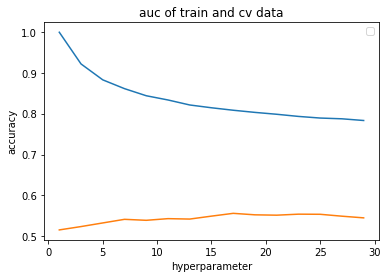

In [330]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [391]:
knn = KNeighborsClassifier(23)
knn.fit(tfidf_sent_vectors_train,y_train)
pred_test = knn.predict(tfidf_sent_vectors_test)    

auc_test_1=roc_auc_score(y_test,pred)*100
print(auc_test_1) 

50.0


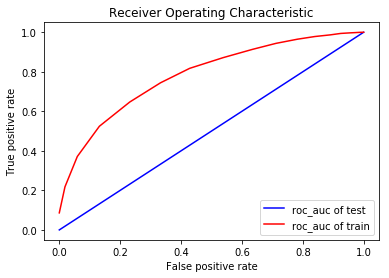

In [332]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

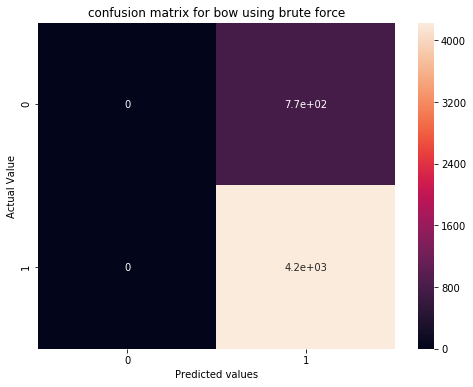

In [333]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using brute force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

# kd-tree

## [5.2] Applying KNN kd-tree

### [5.2.2] Applying KNN kd-tree on BOW,<font color='red'> SET 5 </font>

In [499]:
x_train=preprocessed_reviews[:10000]
x_cv=preprocessed_reviews[10000:15000]
x_test=preprocessed_reviews[15000:20000]
y_train=Final_score[:10000]
y_cv=Final_score[10000:15000]
y_test=Final_score[15000:20000]








  5%|████                                                                         | 2098/40000 [01:16<15:28, 40.82it/s]

In [496]:
#train_BoW
count_vect = CountVectorizer(min_df=10, max_features=500) 
train_bow = count_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_bow))
print("the shape of out text BOW vectorizer ",train_bow.get_shape())
print("the number of unique words ", train_bow.get_shape()[1])
print("********************************************")



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 500)
the number of unique words  500
********************************************






 16%|████████████                                                                 | 6253/40000 [02:29<11:49, 47.55it/s]

In [347]:
#test_BoW

test_bow = count_vect.transform(x_test)
print("the type of count vectorizer ",type(test_bow))
print("the shape of out text BOW vectorizer ",test_bow.get_shape())
print("the number of unique words ", test_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 500)
the number of unique words  500


In [348]:
#cv_BoW

cv_bow = count_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_bow))
print("the shape of out text BOW vectorizer ",cv_bow.get_shape())
print("the number of unique words ", cv_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 500)
the number of unique words  500


In [349]:
A=train_bow.toarray() 
B=cv_bow.toarray()
C=train_bow.toarray()

In [350]:
from scipy import sparse
sparse.save_npz("train_bow_sparse.npz",train_bow)
sparse.save_npz("test_bow_sparse.npz",test_bow)
sparse.save_npz("cv_bow_sparse.npz",cv_bow)

In [351]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")

    # fitting the model on crossvalidation traincc
    knn.fit(A, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(A[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 92%

CV accuracy for k = 5 is 88%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 84%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 82%

CV accuracy for k = 17 is 82%

CV accuracy for k = 19 is 81%

CV accuracy for k = 21 is 81%

CV accuracy for k = 23 is 81%

CV accuracy for k = 25 is 81%

CV accuracy for k = 27 is 80%

CV accuracy for k = 29 is 80%
[0.9986693280106455, 0.9237372808421838, 0.8851407459295837, 0.8617857063715729, 0.8545797268199468, 0.8454840740236994, 0.8372178008738712, 0.82759556404041, 0.8229285417239743, 0.8167396328131467, 0.812598489811793, 0.8125915600441657, 0.8102276479562157, 0.8094320166696538, 0.8079887457441635]


In [352]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")

    # fitting the model on crossvalidation traincc
    knn.fit(A, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(B[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 58.758413%

CV accuracy for k = 3 is 64.525695%

CV accuracy for k = 5 is 67.339912%

CV accuracy for k = 7 is 68.625123%

CV accuracy for k = 9 is 69.737832%

CV accuracy for k = 11 is 69.503520%

CV accuracy for k = 13 is 70.339545%

CV accuracy for k = 15 is 70.170198%

CV accuracy for k = 17 is 70.429005%

CV accuracy for k = 19 is 69.742290%

CV accuracy for k = 21 is 70.492271%

CV accuracy for k = 23 is 70.923212%

CV accuracy for k = 25 is 71.051582%

CV accuracy for k = 27 is 70.863056%

CV accuracy for k = 29 is 71.262227%
[0.5875841294895614, 0.6452569472698664, 0.6733991193670619, 0.6862512316116097, 0.6973783216748937, 0.6950351959059025, 0.7033954490419165, 0.7017019830785143, 0.7042900524997426, 0.6974228986622615, 0.7049227087122123, 0.7092321238621381, 0.7105158185499091, 0.7086305643109593, 0.7126222726849379]


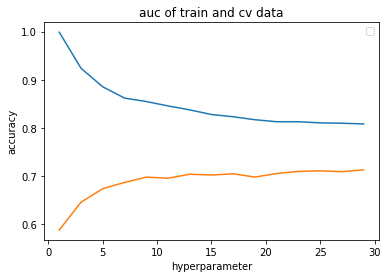

In [353]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [392]:
knn = KNeighborsClassifier(25)
knn.fit(train_bow,y_train)
pred_test = knn.predict(test_bow)
auc_test_1=roc_auc_score(y_test,pred_test)*100
print(auc_test_1) 

55.631101656721306


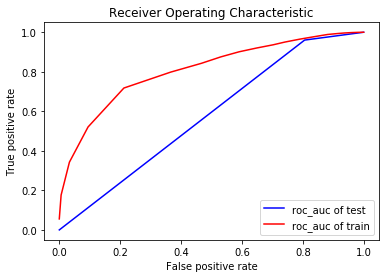

In [355]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

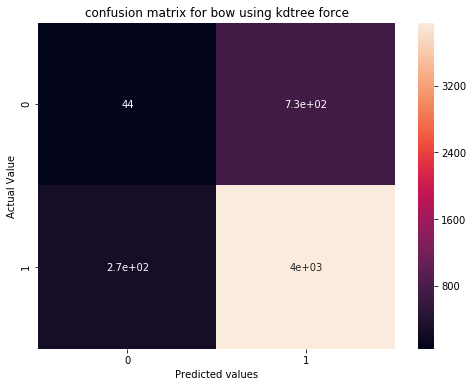

In [356]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using kdtree force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

# [5.2.2] Applying KNN kd-tree on tfidf,<font color='red'> SET 5 </font>

In [357]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=500, min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 500)
the number of unique words including both unigrams and bigrams  500


In [358]:

test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(test_tf_idf))
print("the shape of out text TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", test_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 500)
the number of unique words including both unigrams and bigrams  500


In [359]:

cv_tf_idf = tf_idf_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_tf_idf))
print("the shape of out text TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 500)
the number of unique words including both unigrams and bigrams  500


In [360]:
B1=test_tf_idf.toarray()
A1=train_tf_idf.toarray()
C1=cv_tf_idf.toarray()

In [361]:
sparse.save_npz("train_td_idf_sparse.npz",train_tf_idf)
sparse.save_npz("test_td_idf_sparse.npz",test_tf_idf)
sparse.save_npz("cv_td_idf_sparse.npz",cv_tf_idf)

In [362]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")

    # fitting the model on crossvalidation traincc
    knn.fit(A1, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(A1[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 94%

CV accuracy for k = 5 is 90%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 86%

CV accuracy for k = 13 is 86%

CV accuracy for k = 15 is 88%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 80%

CV accuracy for k = 21 is 77%

CV accuracy for k = 23 is 77%

CV accuracy for k = 25 is 81%

CV accuracy for k = 27 is 85%

CV accuracy for k = 29 is 88%
[0.9986693280106455, 0.9410810797689859, 0.9029888909952252, 0.8750412947593496, 0.8683408750346784, 0.8615421074214209, 0.8640540894594634, 0.8833293359927981, 0.8525912750232146, 0.8078651453125291, 0.7748681367013728, 0.7773064361254347, 0.8110889750059332, 0.8586616731622472, 0.8867118847707275]


In [363]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")

    # fitting the model on crossvalidation traincc
    knn.fit(A1, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(B1[j:(j+500),:])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 49.788053%

CV accuracy for k = 3 is 50.412912%

CV accuracy for k = 5 is 50.002742%

CV accuracy for k = 7 is 50.811025%

CV accuracy for k = 9 is 49.620069%

CV accuracy for k = 11 is 49.016855%

CV accuracy for k = 13 is 49.368646%

CV accuracy for k = 15 is 49.439540%

CV accuracy for k = 17 is 49.466118%

CV accuracy for k = 19 is 49.251857%

CV accuracy for k = 21 is 49.331223%

CV accuracy for k = 23 is 49.230733%

CV accuracy for k = 25 is 51.306948%

CV accuracy for k = 27 is 51.001787%

CV accuracy for k = 29 is 51.185304%
[0.4978805250954652, 0.504129115788648, 0.5000274202087244, 0.5081102543614984, 0.49620069264366345, 0.490168553095328, 0.4936864586448106, 0.49439540124803316, 0.4946611781314798, 0.4925185722128813, 0.4933122264106548, 0.49230732937583643, 0.5130694825025367, 0.5100178736868937, 0.5118530362596262]


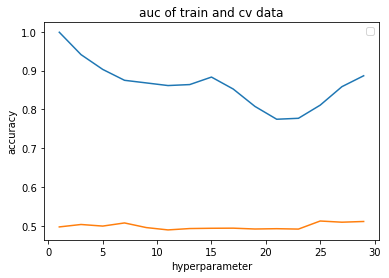

In [364]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [394]:
knn = KNeighborsClassifier(25)
knn.fit(train_tf_idf,y_train)
pred_test = knn.predict(test_tf_idf)
auc_test_1=roc_auc_score(y_test,pred_test)*100
print(auc_test_1)

50.06553079947575


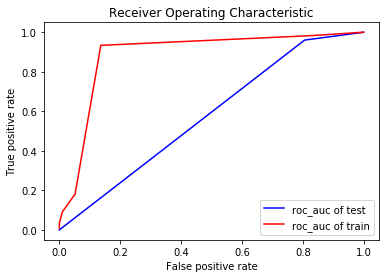

In [367]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

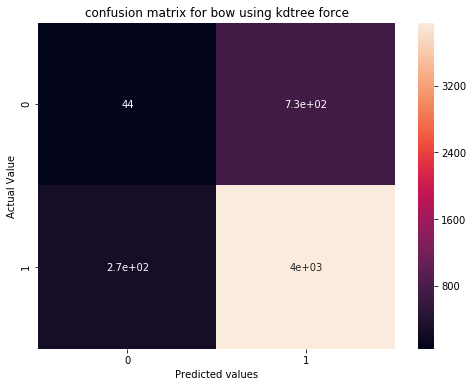

In [368]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using kdtree force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [369]:
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation traincc
    knn.fit(tfidf_sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(tfidf_sent_vectors_train[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 92%

CV accuracy for k = 5 is 88%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 84%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 82%

CV accuracy for k = 15 is 81%

CV accuracy for k = 17 is 80%

CV accuracy for k = 19 is 80%

CV accuracy for k = 21 is 79%

CV accuracy for k = 23 is 79%

CV accuracy for k = 25 is 78%

CV accuracy for k = 27 is 78%

CV accuracy for k = 29 is 78%
[0.999001996007984, 0.9214820525674163, 0.8825705851644561, 0.8610684558465355, 0.8437374593717903, 0.8333881450546791, 0.8211607854081175, 0.8143238061948365, 0.8082866474496769, 0.8030233127562303, 0.7984374900898451, 0.7931918517521468, 0.789192201294324, 0.7873491963153056, 0.7832008494877178]


In [370]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation traincc
    knn.fit(tfidf_sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(tfidf_sent_vectors_cv[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 51.566046%

CV accuracy for k = 3 is 52.384317%

CV accuracy for k = 5 is 53.272181%

CV accuracy for k = 7 is 54.115819%

CV accuracy for k = 9 is 53.887757%

CV accuracy for k = 11 is 54.321486%

CV accuracy for k = 13 is 54.326924%

CV accuracy for k = 15 is 55.015386%

CV accuracy for k = 17 is 55.699267%

CV accuracy for k = 19 is 55.338684%

CV accuracy for k = 21 is 55.202456%

CV accuracy for k = 23 is 55.450770%

CV accuracy for k = 25 is 55.415568%

CV accuracy for k = 27 is 54.947647%

CV accuracy for k = 29 is 54.538933%
[0.5156604624487136, 0.5238431735628747, 0.5327218065107524, 0.5411581928519958, 0.5388775667766335, 0.5432148616918544, 0.5432692425527327, 0.5501538595399043, 0.5569926740555193, 0.5533868400154901, 0.552024561154112, 0.554507698491674, 0.5541556781584405, 0.5494764731545434, 0.5453893301993618]


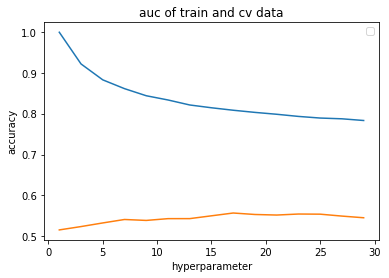

In [371]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [395]:
knn = KNeighborsClassifier(23)
knn.fit(tfidf_sent_vectors_train,y_train)
pred = knn.predict(tfidf_sent_vectors_test)
auc_test_1=roc_auc_score(y_test,pred)*100
print(auc_test_1) 
 

50.0


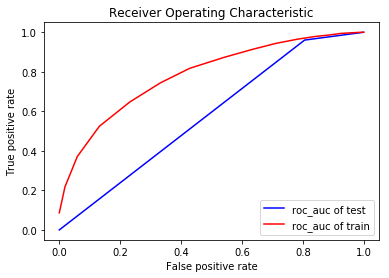

In [373]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

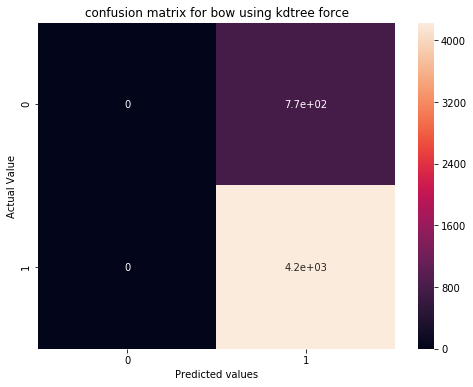

In [374]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using kdtree force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

# avg_w2v

In [378]:
list_cv=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")

    # fitting the model on crossvalidation traincc
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,5000,500):
            predicted_labels =knn.predict_proba(sent_vectors_cv[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_cv=roc_auc_score(y_cv,pred)
    print('\nCV accuracy for k = %d is %f%%' % (i, auc_cv*100))
    list_cv.append(auc_cv)
print(list_cv)
pred_cv=pred


CV accuracy for k = 1 is 49.964522%

CV accuracy for k = 3 is 47.406401%

CV accuracy for k = 5 is 48.098232%

CV accuracy for k = 7 is 46.084884%

CV accuracy for k = 9 is 46.901562%

CV accuracy for k = 11 is 46.836903%

CV accuracy for k = 13 is 47.162070%

CV accuracy for k = 15 is 47.109481%

CV accuracy for k = 17 is 46.823959%

CV accuracy for k = 19 is 46.886290%

CV accuracy for k = 21 is 48.424809%

CV accuracy for k = 23 is 49.124667%

CV accuracy for k = 25 is 49.805271%

CV accuracy for k = 27 is 49.959283%

CV accuracy for k = 29 is 50.053063%
[0.49964522232734154, 0.474064005813697, 0.4809823236160607, 0.46084884387821634, 0.46901562369792305, 0.46836902760280585, 0.47162069671227097, 0.47109481080975096, 0.4682395858353636, 0.46886289773089346, 0.4842480857936971, 0.49124667281042744, 0.49805270562399206, 0.49959283287827017, 0.5005306346537517]


In [380]:
# [6] Conclusions
list_train=[]
from sklearn.metrics import roc_auc_score
for i in range(1,30,2):
    
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation traincc
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train


    predicted_labels=[]
    pred=[]
    for j in range(0,10000,500):
            predicted_labels =knn.predict_proba(sent_vectors_train[j:(j+500)])
            pred.extend(predicted_labels[:,1])
    
    # evaluate CV accuracy
    auc_train=roc_auc_score(y_train,pred)
    
    print('\nCV accuracy for k = %d is %d%%' % (i, auc_train*100))
    list_train.append(auc_train)
print(list_train)
pred_train=pred


CV accuracy for k = 1 is 99%

CV accuracy for k = 3 is 92%

CV accuracy for k = 5 is 89%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 84%

CV accuracy for k = 13 is 84%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 82%

CV accuracy for k = 23 is 82%

CV accuracy for k = 25 is 82%

CV accuracy for k = 27 is 81%

CV accuracy for k = 29 is 81%
[0.999001996007984, 0.9289129167814776, 0.8961193379589728, 0.8754054011940029, 0.8613596626917989, 0.8495765911979737, 0.8440188001072118, 0.8395144511494841, 0.8349831661458378, 0.8300488192341534, 0.8275570392305498, 0.82395673131396, 0.8214071249443368, 0.817768096461739, 0.8152184117896568]


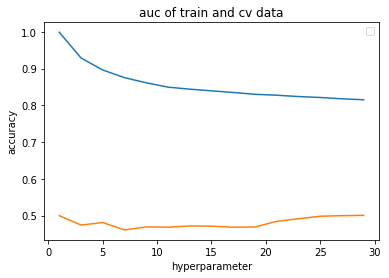

In [381]:
plt.title('')
y1=list_train
y2=list_cv
x=np.arange(1,30,2)
plt.legend()
plt.xlabel('hyperparameter')
plt.ylabel('accuracy')
plt.title("auc of train and cv data")
plt.plot(x,y1)
plt.plot(x,y2)


In [382]:
len(y_test)

5000

In [387]:
knn = KNeighborsClassifier(25)
knn.fit(sent_vectors_train,y_train)
pred = knn.predict(sent_vectors_train)
auc_test_1=roc_auc_score(y_test,pred_test)*100
print(auc_test_1)

57.71602351004429


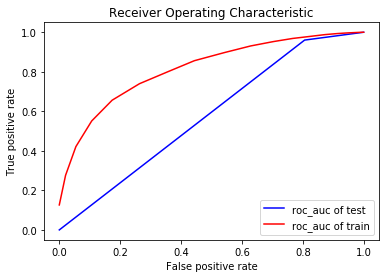

In [384]:
fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
roc_auc=metrics.auc(fbr_train,tpr_train)
fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
roc_auc=metrics.auc(fbr_test,tpr_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
plt.legend()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
plt.legend(loc='lower right')
plt.show()

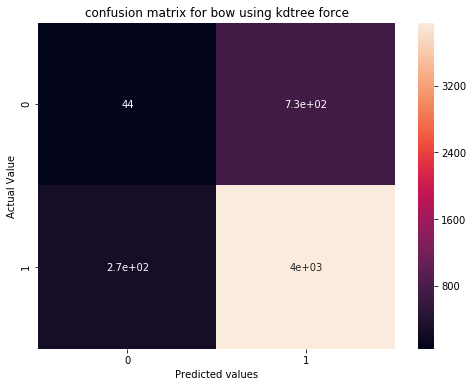

In [385]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_cv,pred_test)
plt.figure(figsize=[8,6])
sns.heatmap(confusion,annot=True)
plt.title("confusion matrix for bow using kdtree force")
plt.xlabel("Predicted values")
plt.ylabel("Actual Value")
plt.show()

# [6] Conclusions


In [2]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "model", "Hyperparameter", "AUC"]

x.add_row(["BOW","BRUTE", 18, 54.45])
x.add_row(["TD-IDF", "BRUTE", 15, 50.75])
x.add_row(["AVG W2V", "BRUTE", 25, 49.08])
x.add_row(["TD-IDF W2V", "BRUTE", 23, 50])
x.add_row(["BOW", "KD TREE", 25, 55.63])
x.add_row(["TD-IDF", "KD TREE", 25, 50.06])
x.add_row(["AVG W2V", "KD TREE", 25, 57.71])
x.add_row(["TD-IDF W2V", "KD TREE", 17, 50])

print(x)

+------------+---------+----------------+-------+
| Vectorizer |  model  | Hyperparameter |  AUC  |
+------------+---------+----------------+-------+
|    BOW     |  BRUTE  |       18       | 54.45 |
|   TD-IDF   |  BRUTE  |       15       | 50.75 |
|  AVG W2V   |  BRUTE  |       25       | 49.08 |
| TD-IDF W2V |  BRUTE  |       23       |   50  |
|    BOW     | KD TREE |       25       | 55.63 |
|   TD-IDF   | KD TREE |       25       | 50.06 |
|  AVG W2V   | KD TREE |       25       | 57.71 |
| TD-IDF W2V | KD TREE |       17       |   50  |
+------------+---------+----------------+-------+
